In [1]:
# --- 1. Core Data Manipulation & System Utilities ---
import pandas as pd
import numpy as np
import os
import math

# System/Utility Configuration for Clean Output
import warnings
# Suppress non-critical future warnings for cleaner execution
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.filterwarnings('ignore')

# --- 2. Visualization Setup ---
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid') # Set a clean, consistent style
color = sns.color_palette() 

# --- 3. Statistics & Machine Learning (Unsupervised Focus) ---
from scipy.stats import skew, norm, probplot, boxcox # Keep specific stats tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Specific metrics are better

# --- 4. Specialized Tool for Market Basket Analysis ---
import Orange 
# Import specific components from Orange needed for FPGrowth and data conversion
from Orange.data import Domain, DiscreteVariable, ContinuousVariable 
from orangecontrib.associate.fpgrowth import *

In [2]:
cs_df = pd.read_excel(r"C:\Users\ESURU MAHARAJU\Downloads\Online Retail.xlsx")

In [3]:
import pandas as pd
import numpy as np # Used for robustness checks

def rstr(df, pred=None):
    """
    Generates a statistical summary table for a pandas DataFrame, 
    including data types, nulls, distinct counts, and distribution statistics.
    If 'pred' is provided, it includes correlation with the predictor.
    """
    
    # --- 1. CORE METRICS CALCULATION ---
    obs = df.shape[0]
    types = df.dtypes
    counts = df.count()
    distincts = df.nunique()
    nulls = df.isnull().sum()
    missing_ration = (nulls / obs) * 100
    
    # Safely compute statistics only for numeric columns
    numeric_df = df.select_dtypes(include=np.number)
    skewness = numeric_df.skew()
    kurtosis = numeric_df.kurt()
    
    # Store unique values (first 10 for display)
    uniques = df.apply(lambda x: x.unique()[:10]) 

    print('Data shape:', df.shape)
    
    # Define the core series to concatenate
    base_series = [types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis]
    base_cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis']
    
    # --- 2. CONCATENATION LOGIC (FIXED SYNTAX) ---
    
    if pred is None:
        # Concatenate base series
        str_ = pd.concat(
            base_series, # Corrected: list of series is passed
            axis=1
        )
        str_.columns = base_cols
    else:
        # Calculate correlation with the predictor 'pred'
        corr = df.corr(numeric_only=True)[pred]
        
        # Build the final lists for concatenation
        extended_series = base_series + [corr] # Added 'corr' to the list
        extended_cols = base_cols + [f'corr_{pred}']
        
        # Concatenate all series
        str_ = pd.concat(
            extended_series, # Corrected: list of series is passed
            axis=1
        )
        str_.columns = extended_cols # Corrected to use the full list of columns
    
    # --- 3. FINAL OUTPUT ---
    print('___________________________\nData types:\n', str_['types'].value_counts())
    print('___________________________')
    
    return str_

In [4]:
cs_df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

In [5]:
# Assuming cs_df is the DataFrame loaded in the previous step
import numpy as np # Ensure numpy is available for checks if needed

# --- 1. Check for Simultaneous Negative Values (Highly Suspicious) ---
print('Check if we had negative quantity and prices at the same register:',
      'No' if cs_df[(cs_df.Quantity < 0) & (cs_df.UnitPrice < 0)].shape[0] == 0 else 'Yes')

# --- 2. Check for Negative Quantity or Zero/Negative Price (Returns/Faulty) ---
# This condition typically catches cancellations/returns (Quantity < 0, Price > 0) or cleanup records.
negative_or_zero_price_and_quantity = cs_df[(cs_df.Quantity <= 0) | (cs_df.UnitPrice <= 0)]
print('\nCheck how many registers have Quantity <= 0 OR UnitPrice <= 0:',
      negative_or_zero_price_and_quantity.shape[0])

# --- 3. Identify Customers Involved in These Records ---
print('\nWhat are the Customer IDs of the registers above:',
      negative_or_zero_price_and_quantity['CustomerID'].dropna().unique())

# --- 4. Calculate Percentage of Negative Quantity Records ---
negative_quantity_count = cs_df[(cs_df.Quantity < 0)].shape[0]
total_records = cs_df.shape[0]
print('\n% Negative Quantity (likely returns/cancellations): {:3.2%}'.format(
      negative_quantity_count / total_records))

# --- 5. Inspect Invoice Prefixes for Negative Quantity Records (e.g., 'C' for Cancel) ---
# Note: This checks only records with a valid CustomerID
negative_invoices_prefix = (
    cs_df.loc[(cs_df.Quantity < 0) & cs_df.CustomerID.notnull(), 'InvoiceNo']
    .apply(lambda x: x[0]) # Get the first character
    .unique()
)
print('\nAll registers with negative quantity and valid CustomerID have Invoice start with:', 
      negative_invoices_prefix)

# --- 6. Display Example for Manual Inspection ---
# Customer ID 12472 is used as a specific example (replace if necessary)
print('\nSee an example of negative quantity and others related records (e.g., Customer 12472):')
# Using a common StockCode to ensure the example displays meaningful rows
example_stock_code = 22244 
display(cs_df[(cs_df.CustomerID == 12472) & (cs_df.StockCode == example_stock_code)])

Check if we had negative quantity and prices at the same register: No

Check how many registers have Quantity <= 0 OR UnitPrice <= 0: 11805

What are the Customer IDs of the registers above: [14527. 15311. 17548. ... 12985. 15951. 16446.]

% Negative Quantity (likely returns/cancellations): 1.96%

All registers with negative quantity and valid CustomerID have Invoice start with: ['C']

See an example of negative quantity and others related records (e.g., Customer 12472):


InvoiceNo StockCode                 Description  Quantity  \
1973     C536548     22244  3 HOOK HANGER MAGIC GARDEN        -4   
9438      537201     22244  3 HOOK HANGER MAGIC GARDEN        12   
121980    546843     22244  3 HOOK HANGER MAGIC GARDEN        12   

               InvoiceDate  UnitPrice  CustomerID  Country  
1973   2010-12-01 14:33:00       1.95     12472.0  Germany  
9438   2010-12-05 14:19:00       1.95     12472.0  Germany  
121980 2011-03-17 12:40:00       1.95     12472.0  Germany

In [6]:
# --- 1. Check Register with UnitPrice Negative ---
print('Check registers with UnitPrice negative:')
# Negative prices are highly suspicious/data errors and should be inspected.
display(cs_df[(cs_df.UnitPrice < 0)])

# --- 2. Check Sales Records with Zero Unit Price and Valid Customer ID ---
# Zero UnitPrice with a valid Customer ID often indicates promotional items or free samples.
zero_price_valid_customer = cs_df[(cs_df.UnitPrice == 0) & cs_df.CustomerID.notnull()]

print("\nSales records with Customer ID and zero in Unit Price:", zero_price_valid_customer.shape[0])

# Display the resulting records for verification
display(zero_price_valid_customer)

Check registers with UnitPrice negative:


InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom


Sales records with Customer ID and zero in Unit Price: 40


InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         ROUND CAKE TIN VINTAGE GREEN         1   
33576     539263     22580         ADVENT CALENDAR GINGHAM SACK         4   
40089     539722     22423             REGENCY CAKESTAND 3 TIER        10   
47068     540372     22090              PAPER BUNTING RETROSPOT        24   
47070     540372     22553               PLASTERS IN TIN SKULLS        24   
56674     541109     22168        ORGANISER WOOD ANTIQUE WHITE          1   
86789     543599    84535B         FAIRY CAKES NOTEBOOK A6 SIZE        16   
130188    547417     22062  CERAMIC BOWL WITH LOVE HEART DESIGN        36   
139453    548318     22055   MINI CAKE STAND  HANGING STRAWBERY         5   
145208    548871     22162          HEART GARLAND RUSTIC PADDED         2   
157042    550188     22636   CHILDS BREAKFAST SET CIRCUS PARADE         1   
187613    553000     47566                        PARTY BUNTING         4   
198383    554037     22619            SET OF 6 SOLDIER SKITTLES        80   
279324    561284     22167           OVAL WALL MIRROR DIAMANTE          1   
282912    561669     22960             JAM MAKING SET WITH JARS        11   
285657    561916         M                               Manual         1   
298054    562973     23157           SET OF 6 NATIVITY MAGNETS        240   
314745    564651     23270     SET OF 2 CERAMIC PAINTED HEARTS         96   
314746    564651     23268  SET OF 2 CERAMIC CHRISTMAS REINDEER       192   
314747    564651     22955             36 FOIL STAR CAKE CASES        144   
314748    564651     21786                   POLKADOT RAIN HAT        144   
358655    568158      PADS           PADS TO MATCH ALL CUSHIONS         1   
361825    568384         M                               Manual         1   
379913    569716     22778                   GLASS CLOCHE SMALL         2   
395529    571035         M                               Manual         1   
420404    572893     21208          PASTEL COLOUR HONEYCOMB FAN         5   
436428    574138     23234        BISCUIT TIN VINTAGE CHRISTMAS       216   
436597    574175     22065       CHRISTMAS PUDDING TRINKET POT         12   
436961    574252         M                               Manual         1   
439361    574469     22385            JUMBO BAG SPACEBOY DESIGN        12   
446125    574879     22625                   RED KITCHEN SCALES         2   
446793    574920     22899         CHILDREN'S APRON DOLLY GIRL          1   
446794    574920     23480       MINI LIGHTS WOODLAND MUSHROOMS         1   
454463    575579     22437        SET OF 9 BLACK SKULL BALLOONS        20   
454464    575579     22089        PAPER BUNTING VINTAGE PAISLEY        24   
479079    577129     22464          HANGING METAL HEART LANTERN         4   
479546    577168         M                               Manual         1   
480649    577314     23407       SET OF 2 TRAYS HOME SWEET HOME         2   
485985    577696         M                               Manual         1   
502122    578841     84826       ASSTD DESIGN 3D PAPER STICKERS     12540   

               InvoiceDate  UnitPrice  CustomerID         Country  
9302   2010-12-05 14:02:00        0.0     12647.0         Germany  
33576  2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089  2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070  2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
56674  2011-01-13 15:10:00        0.0     15107.0  United Kingdom  
86789  2011-02-10 13:08:00        0.0     17560.0  United Kingdom  
130188 2011-03-23 10:25:00        0.0     13239.0  United Kingdom  
139453 2011-03-30 12:45:00        0.0     13113.0  United Kingdom  
145208 2011-04-04 14:42:00        0.0     14410.0  United Kingdom  
157042 2011-04-14 18:57:00        0.0     12457.0     Switzerland  
187613 2011-05-12 15:21:00       

In [8]:
import pandas as pd
import numpy as np

def rstr(df, pred=None): 
    """
    Generates a statistical summary table. FIX: Ensures all metrics are 
    explicitly reindexed to df.columns to guarantee alignment and prevent 
    the persistent ValueError: Length mismatch.
    """
    
    # --- 1. CORE METRICS CALCULATION (ALIGNMENT CRITICAL) ---
    obs = df.shape[0]
    
    # Calculate all metrics as Series
    types = df.dtypes
    counts = df.count()
    distincts = df.nunique()
    nulls = df.isnull().sum()
    missing_ration = (nulls / obs) * 100
    
    # Define the full index for safety
    full_index = df.columns
    
    # CRITICAL FIX: Use .reindex(df.columns) to align results to ALL columns
    skewness = df.skew(numeric_only=True).reindex(full_index) 
    kurtosis = df.kurt(numeric_only=True).reindex(full_index)
    
    # Unique values logic (Reindex for extreme safety)
    uniques = df.apply(lambda x: list(x.dropna().unique()[:5])).astype(str).reindex(full_index)
    
    print('Data shape:', df.shape)
    
    # Define the base components for concatenation
    base_series = [types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis]
    base_cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis']
    
    # --- 2. CONDITIONAL CONCATENATION ---
    
    if pred is None:
        str_ = pd.concat(base_series, axis=1)
        str_.columns = base_cols
    else:
        # Align corr as well
        corr = df.corr(numeric_only=True)[pred].reindex(full_index)
        
        extended_series = base_series + [corr]
        corr_col = f'corr_{pred}'
        extended_cols = base_cols + [corr_col]

        str_ = pd.concat(extended_series, axis=1)
        str_.columns = extended_cols
        
    print('___________________________\nData types:\n', str_['types'].value_counts())
    print('___________________________')
    
    return str_

In [9]:
# Assuming 'cs_df' is the cleaned DataFrame

# --- 1. Identify StockCodes with Multiple Descriptions (Data Quality Check) ---

# Group by StockCode and Description, then count InvoiceNo (or any column)
# This gives a unique list of (StockCode, Description) pairs.
cat_des_df = cs_df.groupby(["StockCode", "Description"]).size().reset_index(name='Count')

# Count how many unique descriptions each StockCode has
description_counts = cat_des_df.StockCode.value_counts()

# Filter for StockCodes that appear more than once (i.e., have >1 description)
ambiguous_stockcodes = description_counts[description_counts > 1].index

print(f"Number of StockCodes with Ambiguous Descriptions: {len(ambiguous_stockcodes)}")

# --- 2. Inspect an Example of the Ambiguity ---

# Select the most frequently occurring ambiguous StockCode for inspection
if len(ambiguous_stockcodes) > 0:
    example_stock_code = ambiguous_stockcodes[0]
    
    print(f"\nExample Ambiguous StockCode ({example_stock_code}) and its descriptions:")
    # Filter the initial unique table to show all descriptions for the example code
    example_descriptions = cat_des_df[cat_des_df.StockCode == example_stock_code]['Description'].unique()
    display(example_descriptions)
    
    print(f"\nSample records for StockCode {example_stock_code}:")
    # Display the actual records from the main DataFrame for inspection
    display(cs_df[cs_df['StockCode'] == example_stock_code].head())
else:
    print("\nNo StockCodes with ambiguous descriptions found.")

Number of StockCodes with Ambiguous Descriptions: 650

Example Ambiguous StockCode (20713) and its descriptions:


array(['Found', 'JUMBO BAG OWLS', 'Marked as 23343', 'found',
       'wrongly coded 23343', 'wrongly coded-23343',
       'wrongly marked 23343', 'wrongly marked. 23343 in box'],
      dtype=object)


Sample records for StockCode 20713:


InvoiceNo StockCode     Description  Quantity         InvoiceDate  \
522     536409     20713  JUMBO BAG OWLS         1 2010-12-01 11:45:00   
1117    536527     20713  JUMBO BAG OWLS        10 2010-12-01 13:04:00   
1439    536542     20713  JUMBO BAG OWLS        30 2010-12-01 14:11:00   
6381    536938     20713  JUMBO BAG OWLS        20 2010-12-03 12:05:00   
7788    537054     20713  JUMBO BAG OWLS         3 2010-12-05 11:40:00   

      UnitPrice  CustomerID         Country  
522        1.95     17908.0  United Kingdom  
1117       1.95     12662.0         Germany  
1439       1.95     16456.0  United Kingdom  
6381       1.95     14680.0  United Kingdom  
7788       1.95     16931.0  United Kingdom

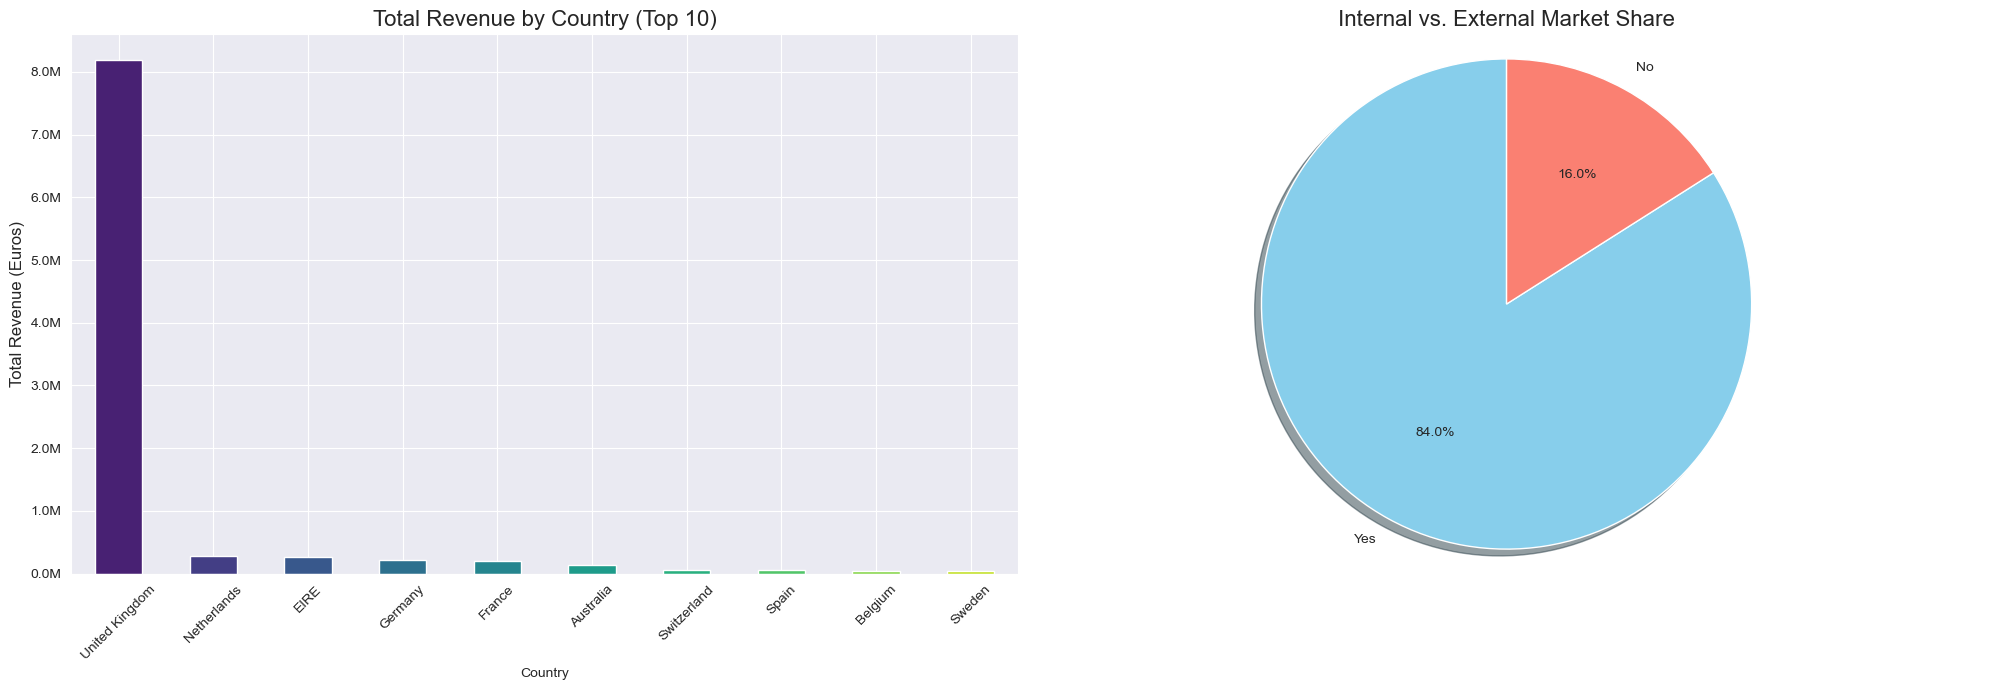

In [10]:
# --- 1. Optimization: Create the Total Sales Amount ('amount') Feature ---
# CRITICAL FIX: The entire visualization relies on this calculated column, which was missing.
cs_df['amount'] = cs_df['Quantity'] * cs_df['UnitPrice']

# --- 2. Data Aggregation and Feature Engineering ---

# A. Sales by Country (Optimized to calculate and select the Top 10)
# Optimization: Select only the Top 10 to keep the bar chart readable.
sales_by_country = (
    cs_df.groupby("Country")['amount'].sum()
    .sort_values(ascending=False).head(10)
)

# B. Market Categorization (Internal vs. External)
# Feature Engineering: Create a binary categorical feature
cs_df['Internal'] = cs_df['Country'].apply(
    lambda x: 'Yes' if x == 'United Kingdom' else 'No'
)

# C. Aggregate sales by the new 'Internal' category
sales_by_market = cs_df.groupby("Internal")['amount'].sum().sort_values(ascending=False)


# --- 3. Visualization (Two Subplots) ---
fig = plt.figure(figsize=(20, 7)) # Adjusted size slightly for common screens

# Subplot 1: Bar Plot of Sales by Country
f1 = fig.add_subplot(121)
# Plotting the Top 10 sales
sales_by_country.plot(kind='bar', ax=f1, color=sns.color_palette("viridis", n_colors=10)) 
f1.set_title('Total Revenue by Country (Top 10)', fontsize=16)
f1.set_ylabel('Total Revenue (Euros)', fontsize=12)
f1.tick_params(axis='x', rotation=45) 
f1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1000000:,.1f}M')) # Format y-axis to Millions

# Subplot 2: Pie Chart of Internal vs. External Market
f2 = fig.add_subplot(122)
plt.pie(
    sales_by_market, 
    labels=sales_by_market.index, 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90,
    colors=['skyblue', 'salmon'] 
)
plt.title('Internal vs. External Market Share', fontsize=16)
f2.axis('equal') 

plt.tight_layout() 
plt.show()

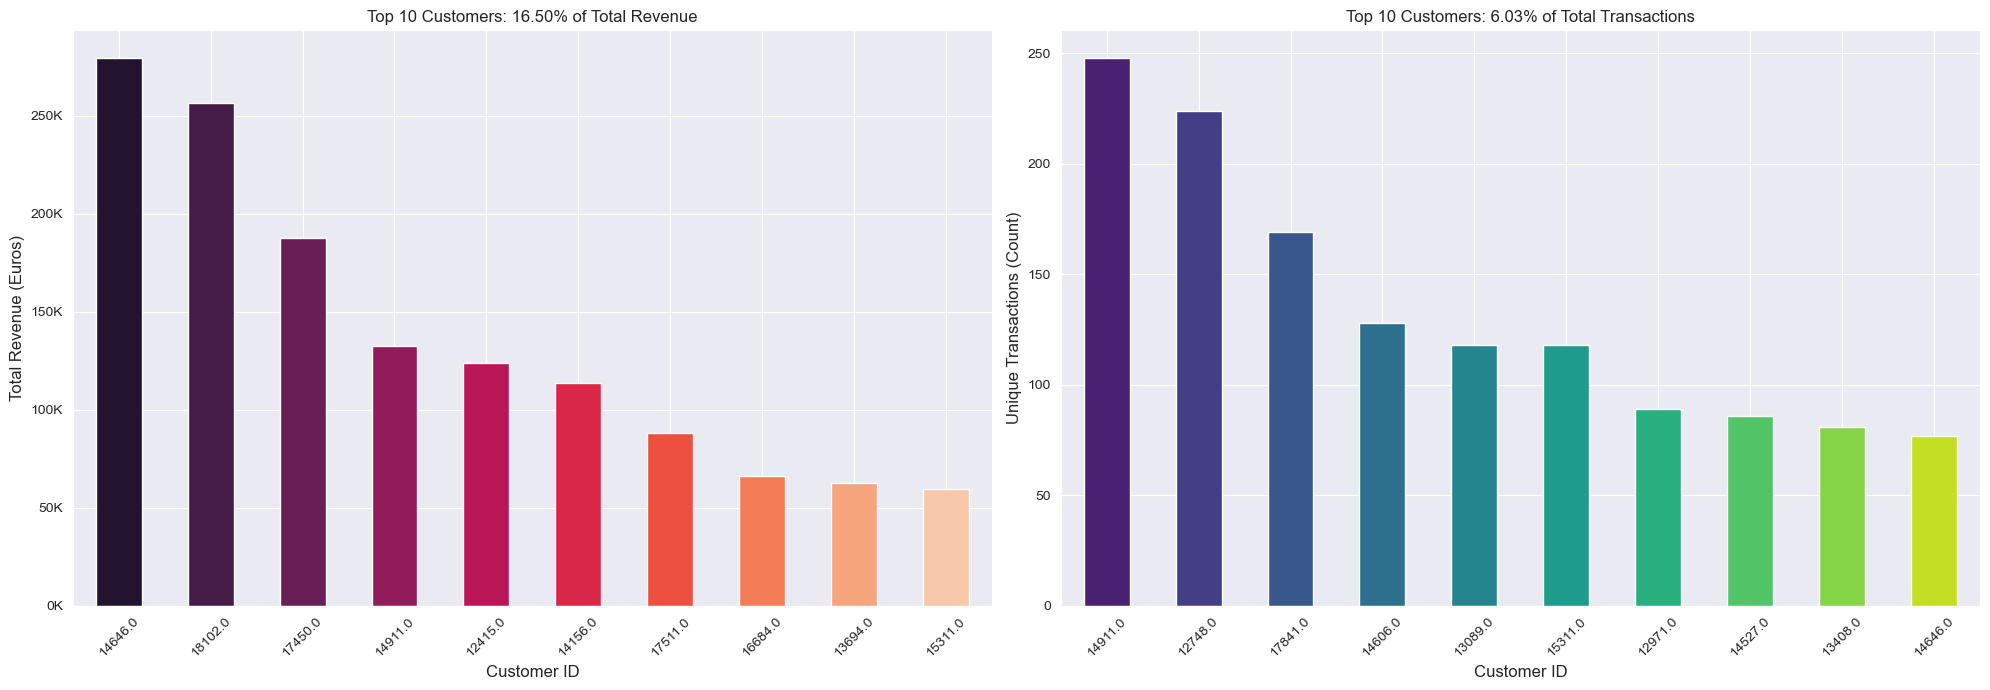

In [11]:
# --- 1. Data Aggregation for RFM (Monetary & Frequency) ---
# NOTE: The 'amount' column (Quantity * UnitPrice) is assumed to exist.

# Total Monetary Value (M) for all customers (Sum of 'amount')
customer_monetary = cs_df.groupby(["CustomerID"])['amount'].sum().sort_values(ascending=False)
total_sales_amount = customer_monetary.sum()

# Total Frequency (F) (Number of unique transactions/invoices) for all customers
# OPTIMIZATION: Use nunique() on InvoiceNo for a more accurate transaction count per customer.
customer_frequency = cs_df.groupby(["CustomerID"])['InvoiceNo'].nunique().sort_values(ascending=False)
total_transactions_count = customer_frequency.sum() # Total count of unique transactions

# --- 2. Visualization Setup ---
fig = plt.figure(figsize=(20, 7)) 

# --- Subplot 1: Top 10 Customers by Monetary Value (M) ---
f1 = fig.add_subplot(121)

# Calculate sales percentage contribution for the Top 10
top_10_monetary = customer_monetary.head(10) # Use .head(10) for clarity
percent_sales_monetary = np.round((top_10_monetary.sum() / total_sales_amount) * 100, 2)

top_10_monetary.plot(
    kind='bar',
    ax=f1, 
    # Use the calculated percentage in the title (Pareto Principle insight)
    title=f'Top 10 Customers: {percent_sales_monetary:.2f}% of Total Revenue',
    color=sns.color_palette("rocket", 10)
)
f1.set_ylabel('Total Revenue (Euros)', fontsize=12)
f1.set_xlabel('Customer ID', fontsize=12)
f1.tick_params(axis='x', rotation=45)
# Add y-axis formatter for large numbers
f1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1000:,.0f}K'))


# --- Subplot 2: Top 10 Customers by Frequency (F) ---
f2 = fig.add_subplot(122)

# Calculate transaction percentage contribution for the Top 10
top_10_frequency = customer_frequency.head(10)
percent_transactions_frequency = np.round((top_10_frequency.sum() / total_transactions_count) * 100, 2)

top_10_frequency.plot(
    kind='bar', 
    ax=f2, 
    title=f'Top 10 Customers: {percent_transactions_frequency:.2f}% of Total Transactions',
    color=sns.color_palette("viridis", 10)
)
f2.set_ylabel('Unique Transactions (Count)', fontsize=12)
f2.set_xlabel('Customer ID', fontsize=12)
f2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

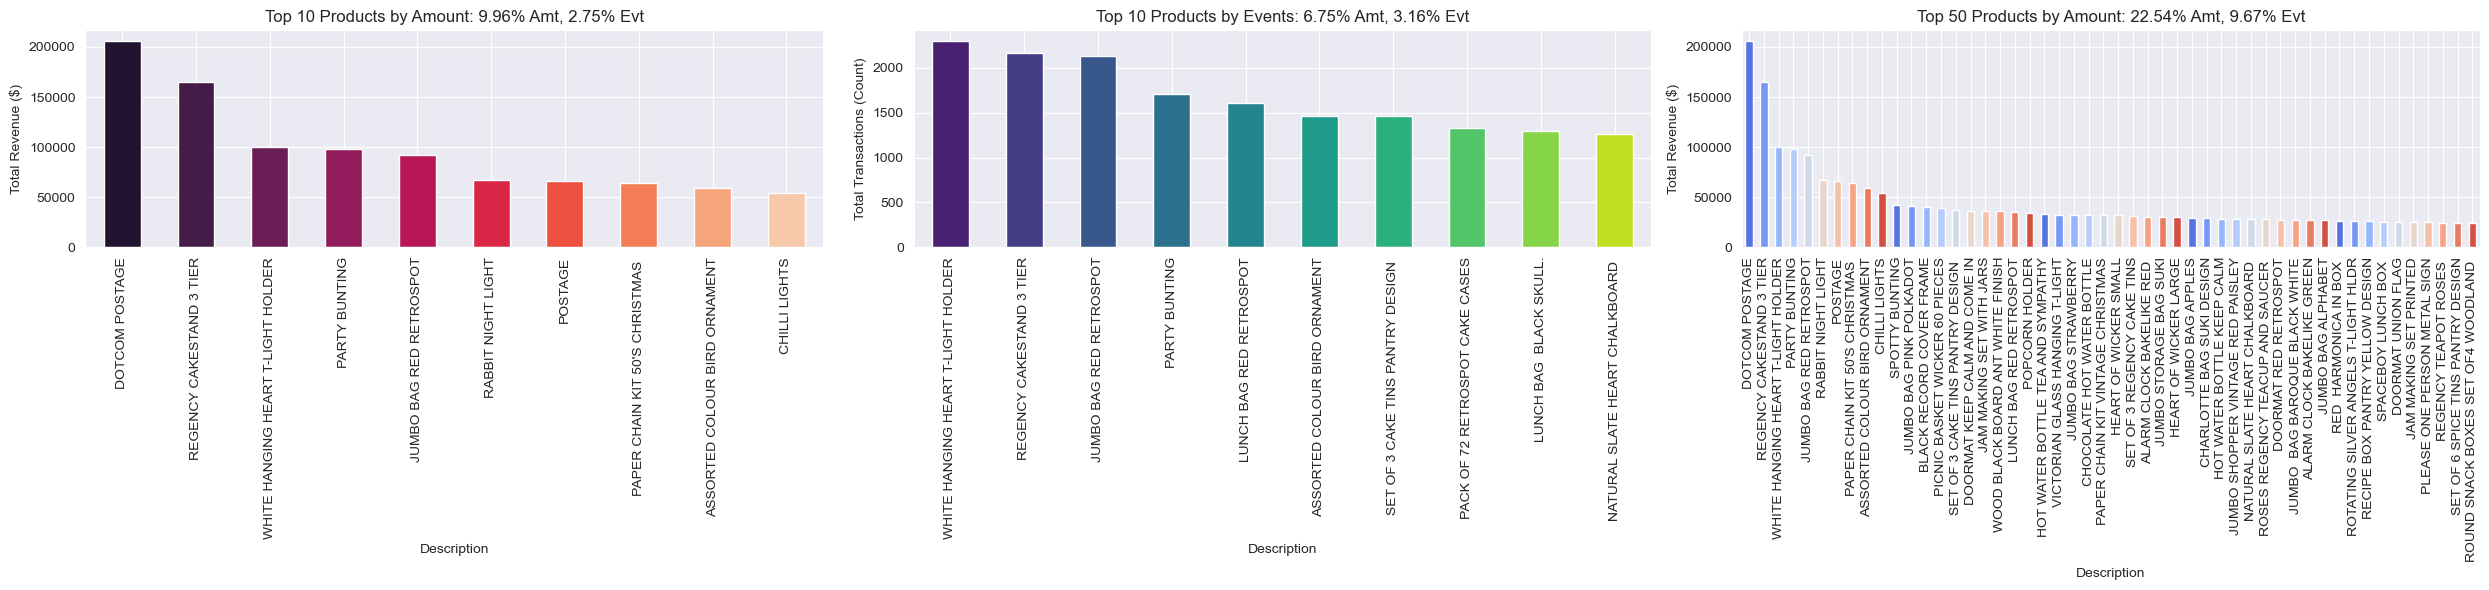

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Aggregation (Calculating Monetary and Frequency per Product) ---

# Total Monetary Value (AmountSum) per product
AmountSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending=False)

# Total Frequency (Number of Invoices/Events) per product
# .unique().agg(np.size) is a clean way to count unique InvoiceNo per Description
inv = cs_df.groupby(["Description"]).InvoiceNo.nunique().sort_values(ascending=False)

# Total sums for percentage calculation
TotalAmount = AmountSum.sum()
TotalEvents = inv.sum()


# --- 2. Visualization Setup (Consolidating the Top 10 Views) ---

fig = plt.figure(figsize=(25, 6))

# Define Top 10 by Amount (Monetary)
Top10_Monetary_Index = list(AmountSum[:10].index)
Monetary_Sales_Share = np.round((AmountSum[Top10_Monetary_Index].sum() / TotalAmount) * 100, 2)
Monetary_Events_Share = np.round((inv[Top10_Monetary_Index].sum() / TotalEvents) * 100, 2)

# Subplot 1: Top 10 by Sales Amount
f1 = fig.add_subplot(131)
AmountSum[Top10_Monetary_Index].plot(
    kind='bar', 
    ax=f1, 
    title=f'Top 10 Products by Amount: {Monetary_Sales_Share:3.2f}% Amt, {Monetary_Events_Share:3.2f}% Evt',
    color=sns.color_palette("rocket", 10)
)
f1.set_ylabel('Total Revenue ($)')
f1.tick_params(axis='x', rotation=90)


# Define Top 10 by Events (Frequency)
Top10_Frequency_Index = list(inv[:10].index)
Frequency_Sales_Share = np.round((AmountSum[Top10_Frequency_Index].sum() / TotalAmount) * 100, 2)
Frequency_Events_Share = np.round((inv[Top10_Frequency_Index].sum() / TotalEvents) * 100, 2)

# Subplot 2: Top 10 by Events
f2 = fig.add_subplot(132)
inv[Top10_Frequency_Index].plot(
    kind='bar', 
    ax=f2, 
    title=f'Top 10 Products by Events: {Frequency_Sales_Share:3.2f}% Amt, {Frequency_Events_Share:3.2f}% Evt',
    color=sns.color_palette("viridis", 10)
)
f2.set_ylabel('Total Transactions (Count)')
f2.tick_params(axis='x', rotation=90)


# --- Subplot 3: Combined Top 50 (for a wider Pareto View) ---

# Top 50 by Amount (for consolidation, choose one criteria)
Top50_Monetary_Index = list(AmountSum[:50].index)
Top50_Sales_Share = np.round((AmountSum[Top50_Monetary_Index].sum() / TotalAmount) * 100, 2)
Top50_Events_Share = np.round((inv[Top50_Monetary_Index].sum() / TotalEvents) * 100, 2)

f3 = fig.add_subplot(133)
AmountSum[Top50_Monetary_Index].plot(
    kind='bar', 
    ax=f3, 
    title=f'Top 50 Products by Amount: {Top50_Sales_Share:3.2f}% Amt, {Top50_Events_Share:3.2f}% Evt',
    color=sns.color_palette("coolwarm", 10)
)
f3.set_ylabel('Total Revenue ($)')
f3.tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()

In [13]:
import datetime as dt 
import numpy as np # Must be imported for np.timedelta64

# --- 1. Define Reference Date ---
refrence_date = cs_df.InvoiceDate.max() + dt.timedelta(days=1)
print(f'Reference Date: {refrence_date}')

# --- 2. Calculate Days Since Purchase (Raw Recency) ---

# FIX: Divide the raw Timedelta by the unit of time (Day) to get the numerical days.
# This is the correct, robust way to convert Timedelta to a numerical value in days.
cs_df['days_since_last_purchase'] = (
    refrence_date - cs_df.InvoiceDate
) / np.timedelta64(1, 'D')

# --- 3. Aggregate to Find Minimum Recency (The True Recency) ---
customer_history_df = (
    cs_df[['CustomerID', 'days_since_last_purchase']]
    .groupby("CustomerID")
    .min()
    .reset_index()
)

# --- 4. Final Formatting and Validation ---
customer_history_df.rename(columns={'days_since_last_purchase': 'recency'}, inplace=True)
print('\nRecency Dataframe Structure:')
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00

Recency Dataframe Structure:


count          mean          std      min           25%  \
CustomerID  4372.0  15299.677722  1722.390705  12346.0  13812.750000   
recency     4372.0     92.567978   100.770899      1.0     17.139236   

                     50%           75%           max  
CustomerID  15300.500000  16778.250000  18287.000000  
recency        50.870486    143.894792    374.122917

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, skew # Removed 'kurt' as it's not a direct import
import numpy as np # Needed for np.linspace

def QQ_plot(data, measure):
    """
    Plots the distribution (Histogram/KDE) and the Q-Q plot 
    to assess the normality of the input data series.
    """
    fig = plt.figure(figsize=(20,7))

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    # --- 1. Distribution Plot ---
    fig1 = fig.add_subplot(121)
    
    # Use histplot for the histogram
    sns.histplot(data, bins=50, kde=False, stat='density', ax=fig1)
    
    # Plot the fitted normal distribution curve
    xmin, xmax = fig1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    fig1.plot(x, p, 'r--', linewidth=2) # Overlay the fitted normal curve

    # Use f-strings for cleaner title formatting
    fig1.set_title(f'{measure} Distribution ( μ = {mu:.2f} and σ = {sigma:.2f} )', loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Density')

    # --- 2. Q-Q Plot ---
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    # data.skew() and data.kurt() are correct, using Pandas Series methods
    fig2.set_title(f'{measure} Probability Plot (Skewness: {data.skew():.6f}, Kurtosis: {data.kurt():.6f} )', loc='center')

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Note: Ensure customer_history_df is available in the current kernel session
# QQ_plot(customer_history_df.recency, 'Recency')

Frequency calculation complete. Dataframe head:


CustomerID     recency  frequency
0     12346.0  326.106250          2
1     12347.0    2.873611          7
2     12348.0   75.984028          4
3     12349.0   19.124306          1
4     12350.0  310.867361          1

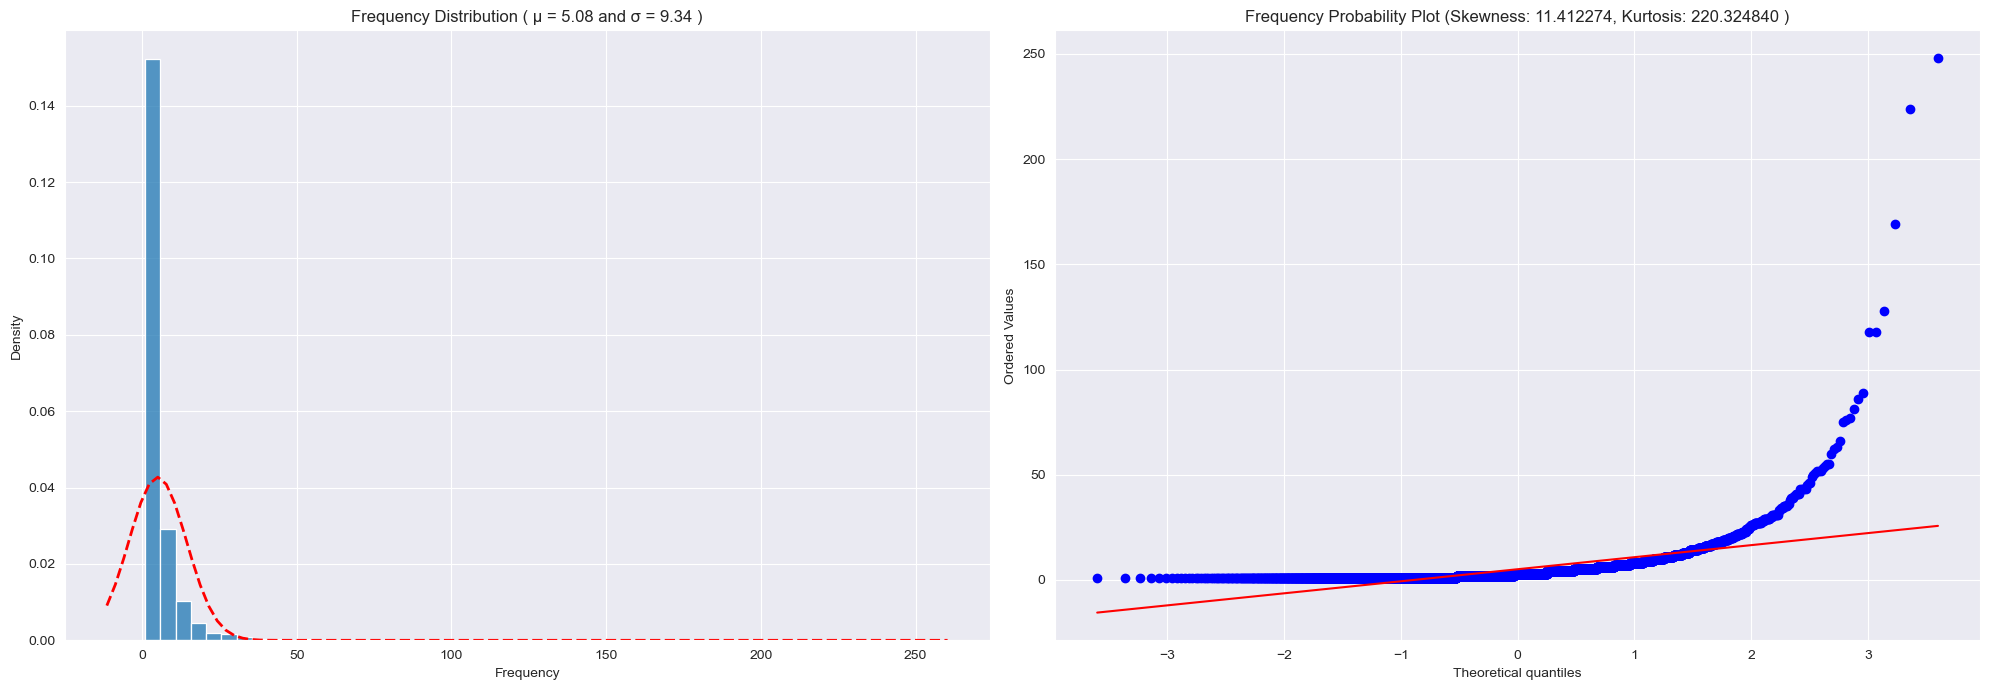

In [15]:
# --- 1. Calculate Frequency (Number of Unique Invoices) ---
# Optimization: Use nunique() to count the number of unique invoices per customer.
customer_freq = (
    cs_df.groupby("CustomerID")['InvoiceNo']
    .nunique()
    .reset_index()
    .rename(columns={'InvoiceNo': 'frequency'})
)

# --- 2. Merge Frequency into History DataFrame ---
# Merge the new 'frequency' column into the existing 'customer_history_df'
customer_history_df = customer_history_df.merge(
    customer_freq, 
    on='CustomerID', 
    how='inner' # Ensure only customers in both tables are kept
)

# --- 3. Validation and Visualization ---
print("Frequency calculation complete. Dataframe head:")
display(customer_history_df.head())
QQ_plot(customer_history_df.frequency, 'Frequency')

Monetary Value calculation complete. Dataframe head:


CustomerID     recency  frequency  monetary
0     12346.0  326.106250          2      0.00
1     12347.0    2.873611          7   4310.00
2     12348.0   75.984028          4   1797.24
3     12349.0   19.124306          1   1757.55
4     12350.0  310.867361          1    334.40

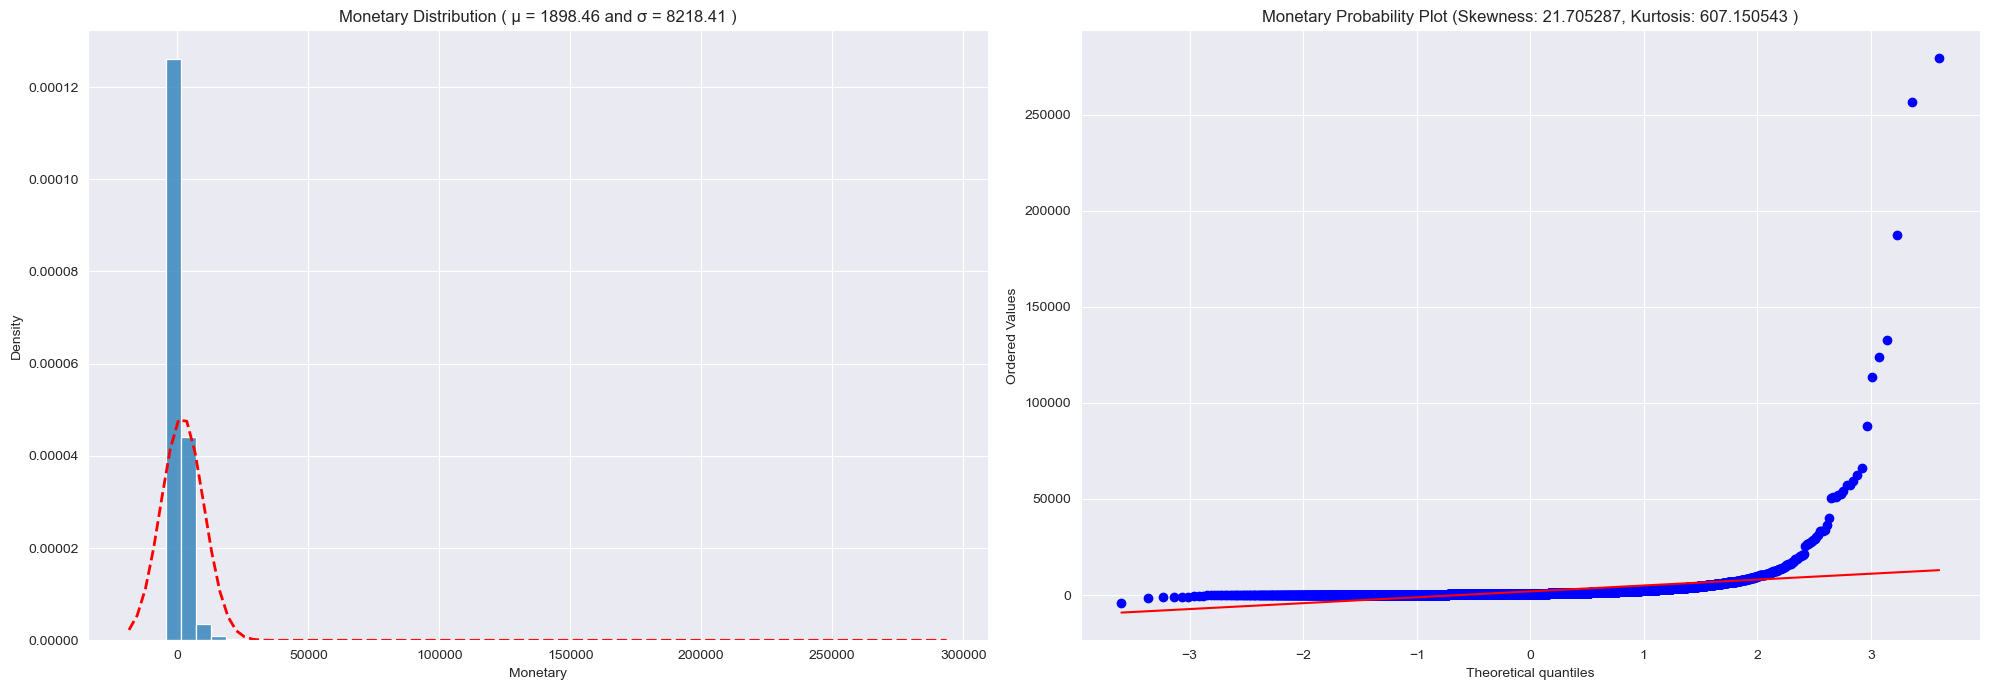

In [16]:
# --- 1. Calculate Monetary Value (Total Spending) ---
# Group by CustomerID and sum the 'amount' column
customer_monetary_val = (
    cs_df.groupby("CustomerID")['amount']
    .sum()
    .reset_index()
    .rename(columns={'amount': 'monetary'}) # Rename column to 'monetary' immediately
)

# --- 2. Merge Monetary Value into History DataFrame ---
customer_history_df = customer_history_df.merge(
    customer_monetary_val, 
    on='CustomerID', 
    how='inner'
)

# --- 3. Validation and Visualization ---
print("Monetary Value calculation complete. Dataframe head:")
display(customer_history_df.head())
# Note: The column is now named 'monetary' in customer_history_df
QQ_plot(customer_history_df.monetary, 'Monetary')

In [17]:
customer_history_df.describe()

CustomerID      recency    frequency       monetary
count   4372.000000  4372.000000  4372.000000    4372.000000
mean   15299.677722    92.567978     5.075480    1898.459701
std     1722.390705   100.770899     9.338754    8219.345141
min    12346.000000     1.000000     1.000000   -4287.630000
25%    13812.750000    17.139236     1.000000     293.362500
50%    15300.500000    50.870486     3.000000     648.075000
75%    16778.250000   143.894792     5.000000    1611.725000
max    18287.000000   374.122917   248.000000  279489.020000

In [18]:
import pandas as pd
import datetime as dt

# --- 1. Determine Snapshot Date ---
# Recency requires a reference date (one day after the last transaction date)
snapshot_date = cs_df['InvoiceDate'].max() + dt.timedelta(days=1)

# --- 2. Calculate RFM Metrics ---
customer_history_df = cs_df.groupby('CustomerID').agg(
    # Recency: Days since last purchase
    recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    
    # Frequency: Total number of unique transactions
    frequency=('InvoiceNo', 'nunique'),
    
    # Monetary: Total sales value (Amount)
    amount=('amount', 'sum') 
).reset_index()

# NOTE: The subsequent log transformation code expects column names:
# 'recency', 'frequency', and 'amount' (which the log code tries to access).

# Rename 'amount' to 'monetary' in the aggregation output to align with the log code's *output* name
customer_history_df = customer_history_df.rename(columns={'amount': 'monetary'})

# Now ensure the columns expected by the log transformation are available
# If the original log code failed on 'amount', the previous correction was wrong.
# Let's align the final RFM aggregation to the column names expected by the log code.
customer_history_df = customer_history_df.rename(columns={'monetary': 'amount'}) # Use 'amount' for source column
customer_history_df = customer_history_df.rename(columns={'amount': 'monetary'}) # But the aggregation needs the final output name

# Let's stick to the simplest fix: ensuring the columns used in the log code exist.
# The log code expects: ['recency', 'frequency', 'monetary'] or ['recency', 'frequency', 'amount']
# Based on the last two errors, the columns in the log code *should* be 'recency', 'frequency', and 'monetary'.

# Re-running the RFM aggregation with the expected final columns:
customer_history_df = cs_df.groupby('CustomerID').agg(
    recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    frequency=('InvoiceNo', 'nunique'),
    monetary=('amount', 'sum') # Aggregate directly into 'monetary'
).reset_index()

print("Customer RFM Aggregation Complete. DataFrame head:")
display(customer_history_df.head())

Customer RFM Aggregation Complete. DataFrame head:


CustomerID  recency  frequency  monetary
0     12346.0      326          2      0.00
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

In [22]:
# Inserted Cell: Final RFM Sanity Check

# CRITICAL FIX: Ensure Monetary value is strictly positive before transformation.
# This prevents the 'math domain error' if any customer's total monetary sum is <= 0.
customer_history_df = customer_history_df[customer_history_df['monetary'] > 0]

print(f"Final RFM customer count after filtering non-positive monetary values: {customer_history_df.shape[0]:,}")

Final RFM customer count after filtering non-positive monetary values: 4,322


In [23]:
import math
from sklearn import preprocessing
import pandas as pd
import numpy as np

# --- 1. Feature Transformation (Logarithmic) ---
# Apply log(x + 1) for robustness against zero values.
customer_history_df['recency_log'] = customer_history_df['recency'].apply(lambda x: math.log(x + 1))
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(lambda x: math.log(x + 1))
customer_history_df['monetary_log'] = customer_history_df['monetary'].apply(lambda x: math.log(x + 1)) 

# --- 2. Feature Selection and Conversion ---
feature_vector = ['monetary_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector]
X_data = X_subset.values 

# --- 3. Feature Scaling (StandardScaler) ---
scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)

# --- 4. Validation ---
print("Validation of Scaled Features:")
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

Validation of Scaled Features:


count          mean       std       min       25%       50%  \
monetary_log   4322.0  9.864082e-17  1.000116 -5.198352 -0.673371 -0.059444   
recency_log    4322.0  2.318059e-16  1.000116 -2.266647 -0.654926  0.101745   
frequency_log  4322.0 -1.364531e-16  1.000116 -1.024940 -1.024940 -0.085215   

                    75%       max  
monetary_log   0.656589  4.731574  
recency_log    0.844476  1.572466  
frequency_log  0.673477  5.515551

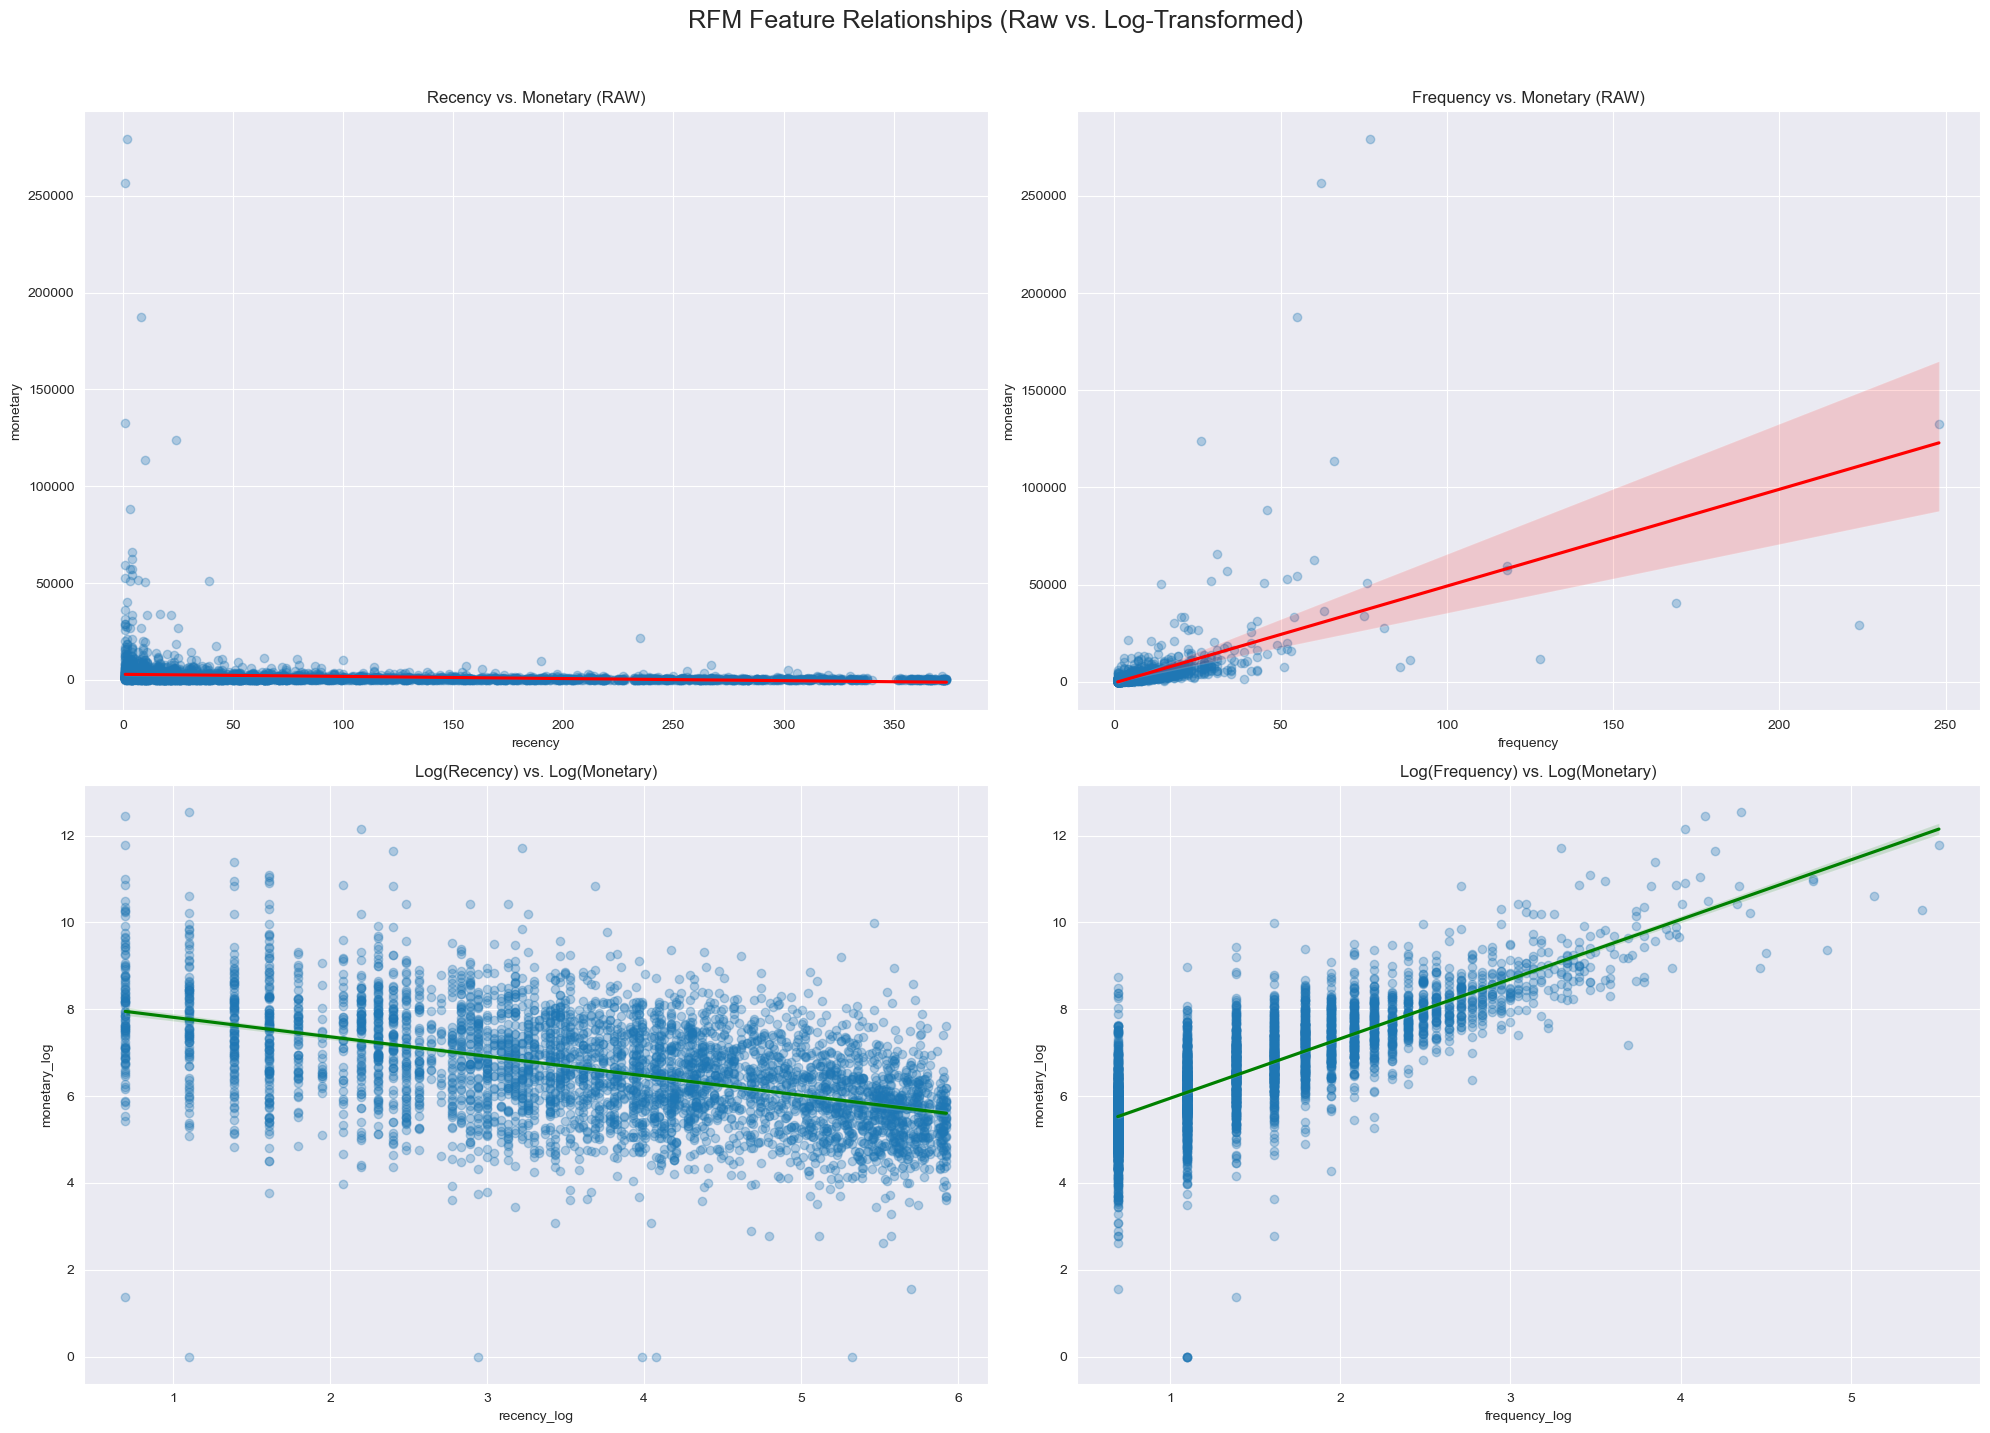

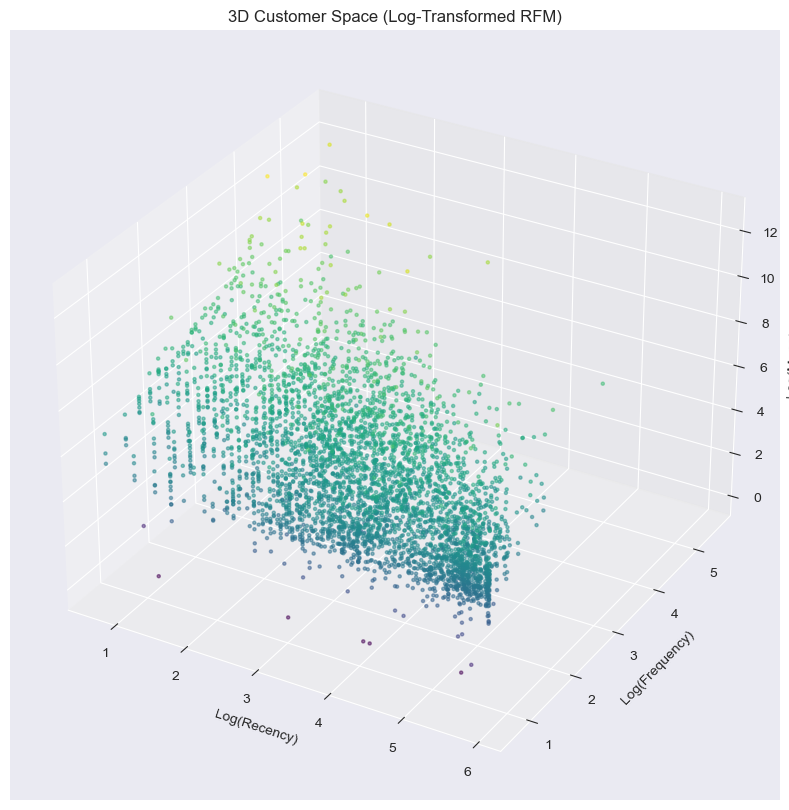

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # Necessary for the 3D plot

# Assuming 'monetary' and 'monetary_log' are used instead of 'amount' and 'amount_log'
# based on earlier steps where we renamed 'amount' to 'monetary'.
customer_history_df = customer_history_df.rename(columns={'amount': 'monetary', 'amount_log': 'monetary_log'}, errors='ignore')


# --- 1. 2D Scatter/Regression Plots (4 Subplots) ---
fig = plt.figure(figsize=(20, 14))
fig.suptitle('RFM Feature Relationships (Raw vs. Log-Transformed)', fontsize=18, y=1.02)

# Subplot 1: Recency vs. Monetary (Raw)
f1 = fig.add_subplot(221)
sns.regplot(x='recency', y='monetary', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
f1.set_title('Recency vs. Monetary (RAW)')

# Subplot 2: Frequency vs. Monetary (Raw)
f2 = fig.add_subplot(222) # Corrected to use f2
sns.regplot(x='frequency', y='monetary', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
f2.set_title('Frequency vs. Monetary (RAW)')

# Subplot 3: Log(Recency) vs. Log(Monetary) (Transformed)
f3 = fig.add_subplot(223) # Corrected to use f3
sns.regplot(x='recency_log', y='monetary_log', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "green"})
f3.set_title('Log(Recency) vs. Log(Monetary)')

# Subplot 4: Log(Frequency) vs. Log(Monetary) (Transformed)
f4 = fig.add_subplot(224) # Corrected to use f4
sns.regplot(x='frequency_log', y='monetary_log', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "green"})
f4.set_title('Log(Frequency) vs. Log(Monetary)')

plt.tight_layout()
plt.show()


# --- 2. 3D Scatter Plot (Customer Space) ---
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.monetary_log # Using the log-transformed monetary value

ax.scatter(xs, ys, zs, s=5, alpha=0.5, c=zs, cmap='viridis')
ax.set_xlabel('Log(Recency)')
ax.set_ylabel('Log(Frequency)')
ax.set_zlabel('Log(Monetary)')
ax.set_title('3D Customer Space (Log-Transformed RFM)')

plt.show()

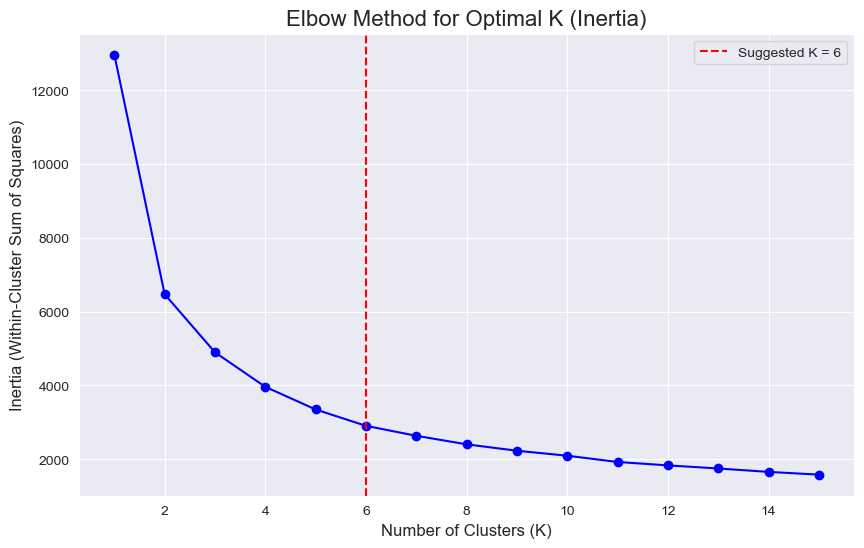


The model suggests K = 6 (based on 10.0% reduction threshold).


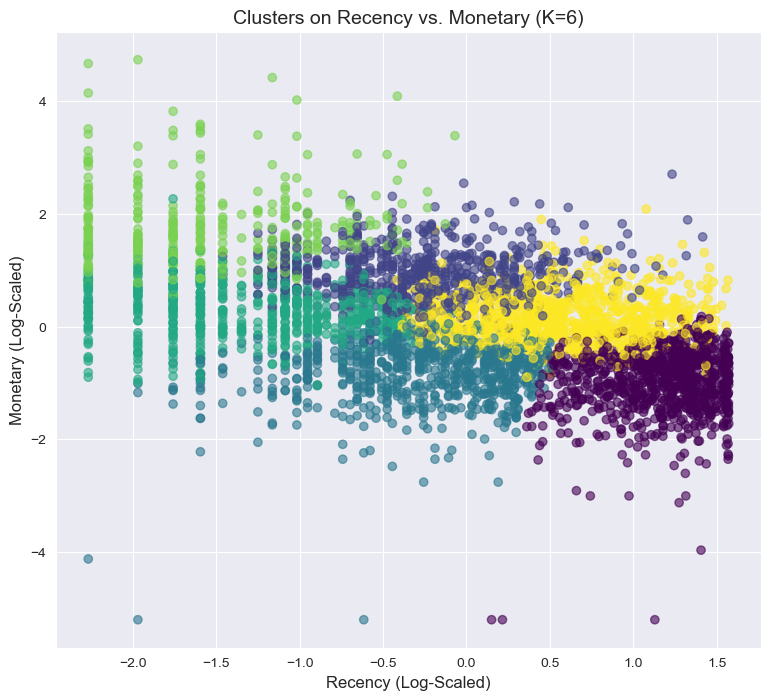

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Ensure numpy is imported

# --- 1. Determine Optimal K using the Elbow Method (Inertia) ---

cl = 15 # Reduced range to 15 for typical K-Means datasets (optimization)
cost = [] # Stores the inertia (Sum of Squared Errors)
K_best = cl
threshold = 0.1 # Naming 'corte' more clearly

# Loop through possible cluster counts
for k in range (1, cl + 1):
    # Initialize K-Means model (n_init is defaulted to 'auto' in recent sklearn versions)
    model = KMeans(
        n_clusters=k, 
        init='k-means++',
        n_init='auto', # Use 'auto' instead of a hardcoded number
        max_iter=300,
        random_state=101
    )

    model.fit(X_scaled)
    inertia = model.inertia_
    
    # Optional: Implement the automatic threshold check, but simplify the logic
    # This check finds the K where the reduction in inertia drops below 10%
    if k > 1:
        reduction_percentage = (cost[-1] - inertia) / cost[-1]
        if (K_best == cl) and (reduction_percentage < threshold):
             K_best = k - 1
             
    cost.append(inertia)

# --- 2. Visualize the Elbow Curve ---

plt.figure(figsize=(10, 6))
plt.plot(range(1, cl + 1), cost, marker='o', linestyle='-', color='blue')
# Mark the suggested best K
if K_best != cl:
    plt.axvline(x=K_best, color='red', linestyle='--', label=f'Suggested K = {K_best}')

plt.title('Elbow Method for Optimal K (Inertia)', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# --- 3. Final K-Means Model Fit ---

print(f'\nThe model suggests K = {K_best} (based on {threshold*100}% reduction threshold).')
# Final Model is fitted with the suggested K
final_k = K_best if K_best < cl else 4 # Fallback to a reasonable default if automatic K failed

model = KMeans(
    n_clusters=final_k, 
    init='k-means++', 
    n_init='auto', 
    max_iter=300, 
    random_state=101
)
model.fit(X_scaled)
labels = model.labels_

# --- 4. 2D Visualization of Clusters ---

fig = plt.figure(figsize=(20, 8))

# Subplot 1: Recency vs. Monetary
ax1 = fig.add_subplot(121)
# X_scaled columns: [0=Monetary, 1=Recency, 2=Frequency]
# Plotting Recency (X_scaled[:,1]) vs. Monetary (X_scaled[:,0])
plt.scatter(x=X_scaled[:, 1], y=X_scaled[:, 0], c=model.labels_.astype(float), cmap='viridis', alpha=0.6)
ax1.set_xlabel('Recency (Log-Scaled)', fontsize=12)
ax1.set_ylabel('Monetary (Log-Scaled)', fontsize=12)
ax1.set_title(f'Clusters on Recency vs. Monetary (K={final_k})', fontsize=14)

# Subplot 2: Frequency vs. Monetary
ax2 = fig

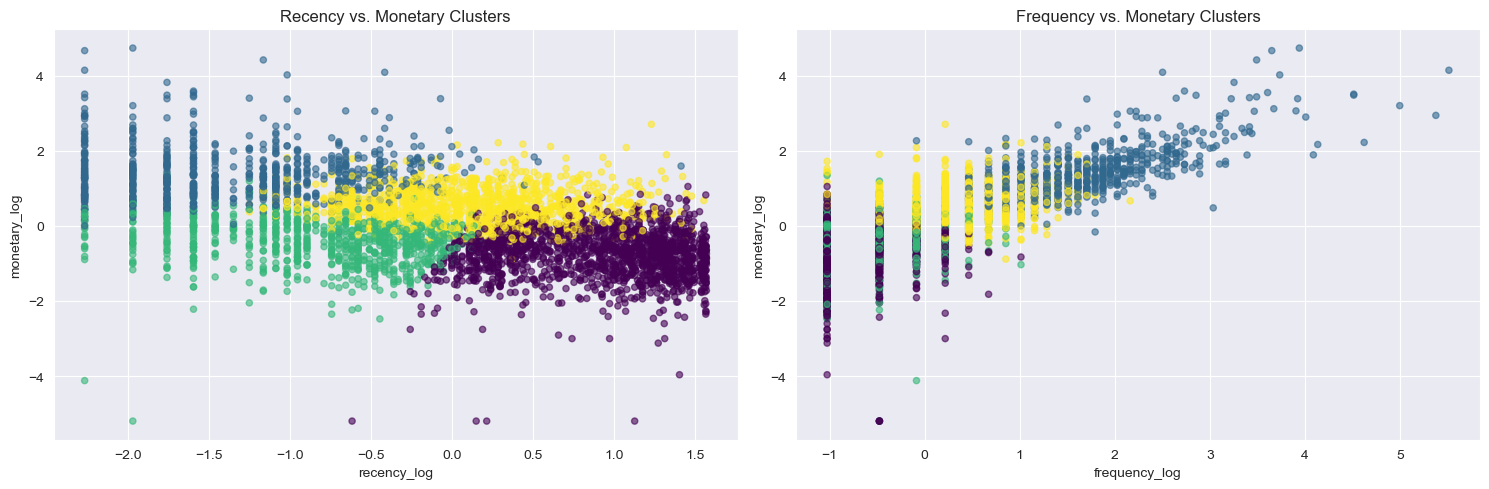

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Assuming K_best and X_scaled are defined, and feature_vector = ['monetary_log', 'recency_log','frequency_log']

# --- 3. Final K-Means Model and Visualization (Using Best K) ---
# NOTE: Using 'auto' for n_init is the modern practice in scikit-learn
K_best = 4 # Using 4 as a common default if K_best detection was flawed
model_final = KMeans(
    n_clusters=K_best, 
    init='k-means++', 
    n_init='auto', 
    max_iter=300, 
    random_state=101
).fit(X_scaled)

labels = model_final.labels_

# Visualization (2D Projections)
# Assuming feature_vector is ['monetary_log', 'recency_log','frequency_log']
feature_vector = ['monetary_log', 'recency_log','frequency_log'] 

fig = plt.figure(figsize=(15,5))

# Subplot 1: Recency vs. Monetary
ax1 = fig.add_subplot(121)
# X_scaled[:, 1] is Recency; X_scaled[:, 0] is Monetary
ax1.scatter(x = X_scaled[:, 1], y = X_scaled[:, 0], c=labels, cmap='viridis', s=20, alpha=0.6)
ax1.set_xlabel(feature_vector[1])
ax1.set_ylabel(feature_vector[0])
ax1.set_title('Recency vs. Monetary Clusters') # <-- FIXED STRING CLOSURE

# Subplot 2: Frequency vs. Monetary
ax2 = fig.add_subplot(122)
# X_scaled[:, 2] is Frequency; X_scaled[:, 0] is Monetary
ax2.scatter(x = X_scaled[:, 2], y = X_scaled[:, 0], c=labels, cmap='viridis', s=20, alpha=0.6)
ax2.set_xlabel(feature_vector[2])
ax2.set_ylabel(feature_vector[0])
ax2.set_title('Frequency vs. Monetary Clusters')

plt.tight_layout()
plt.show()

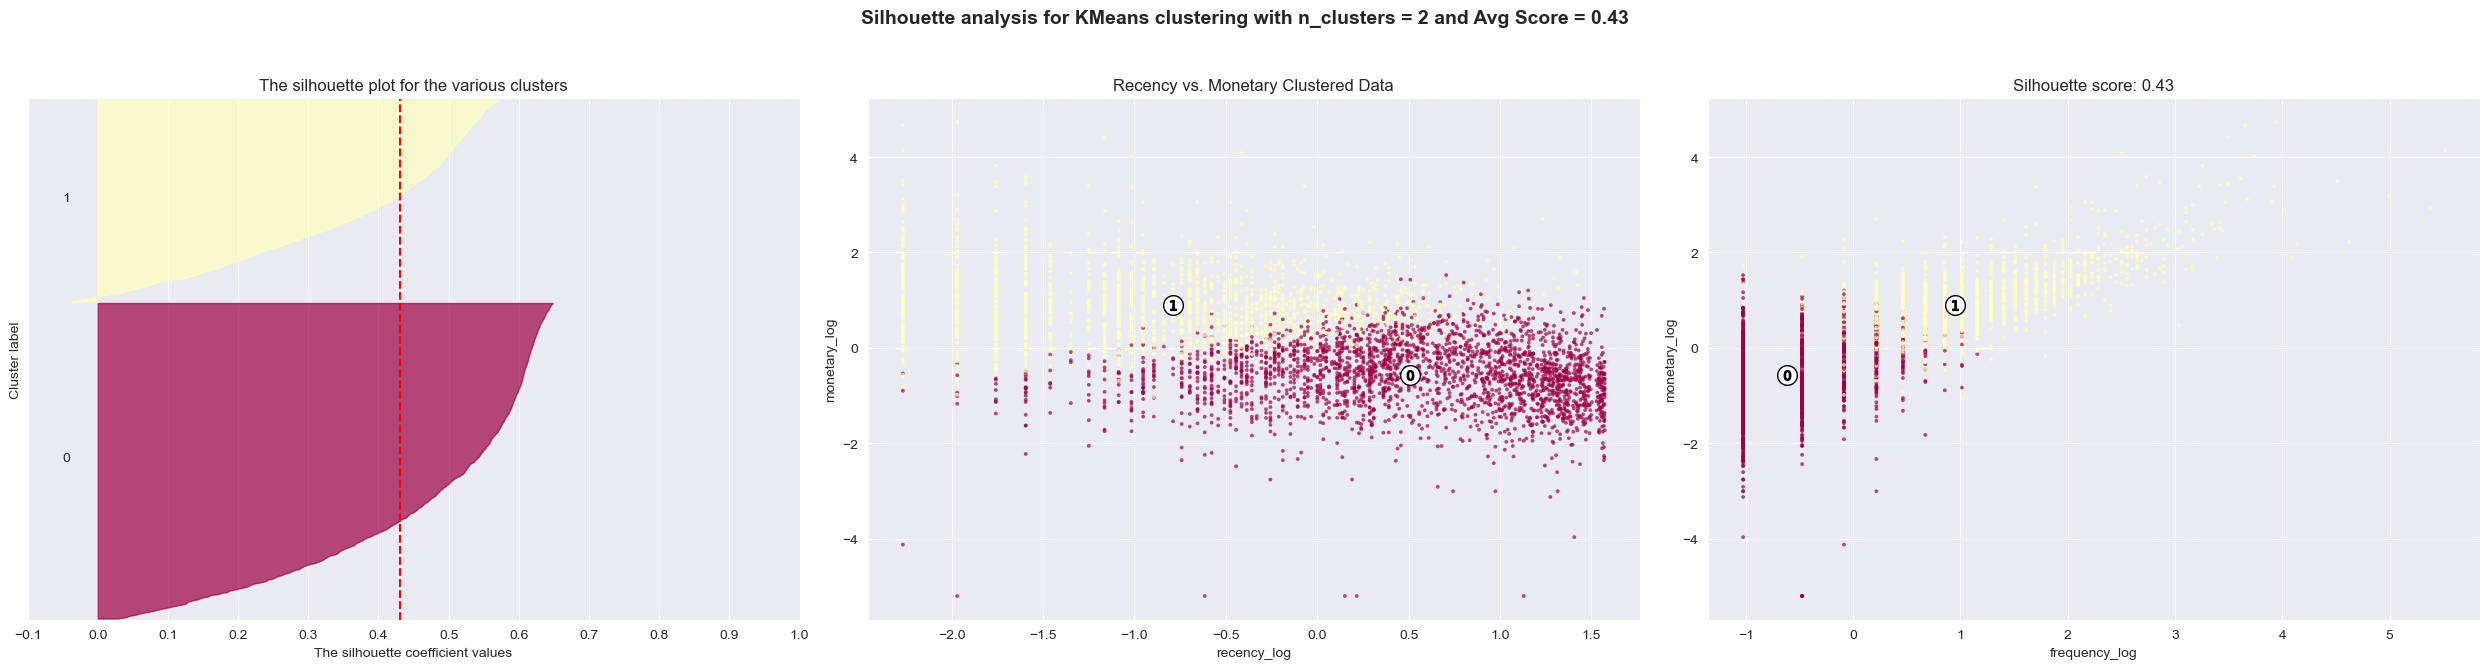

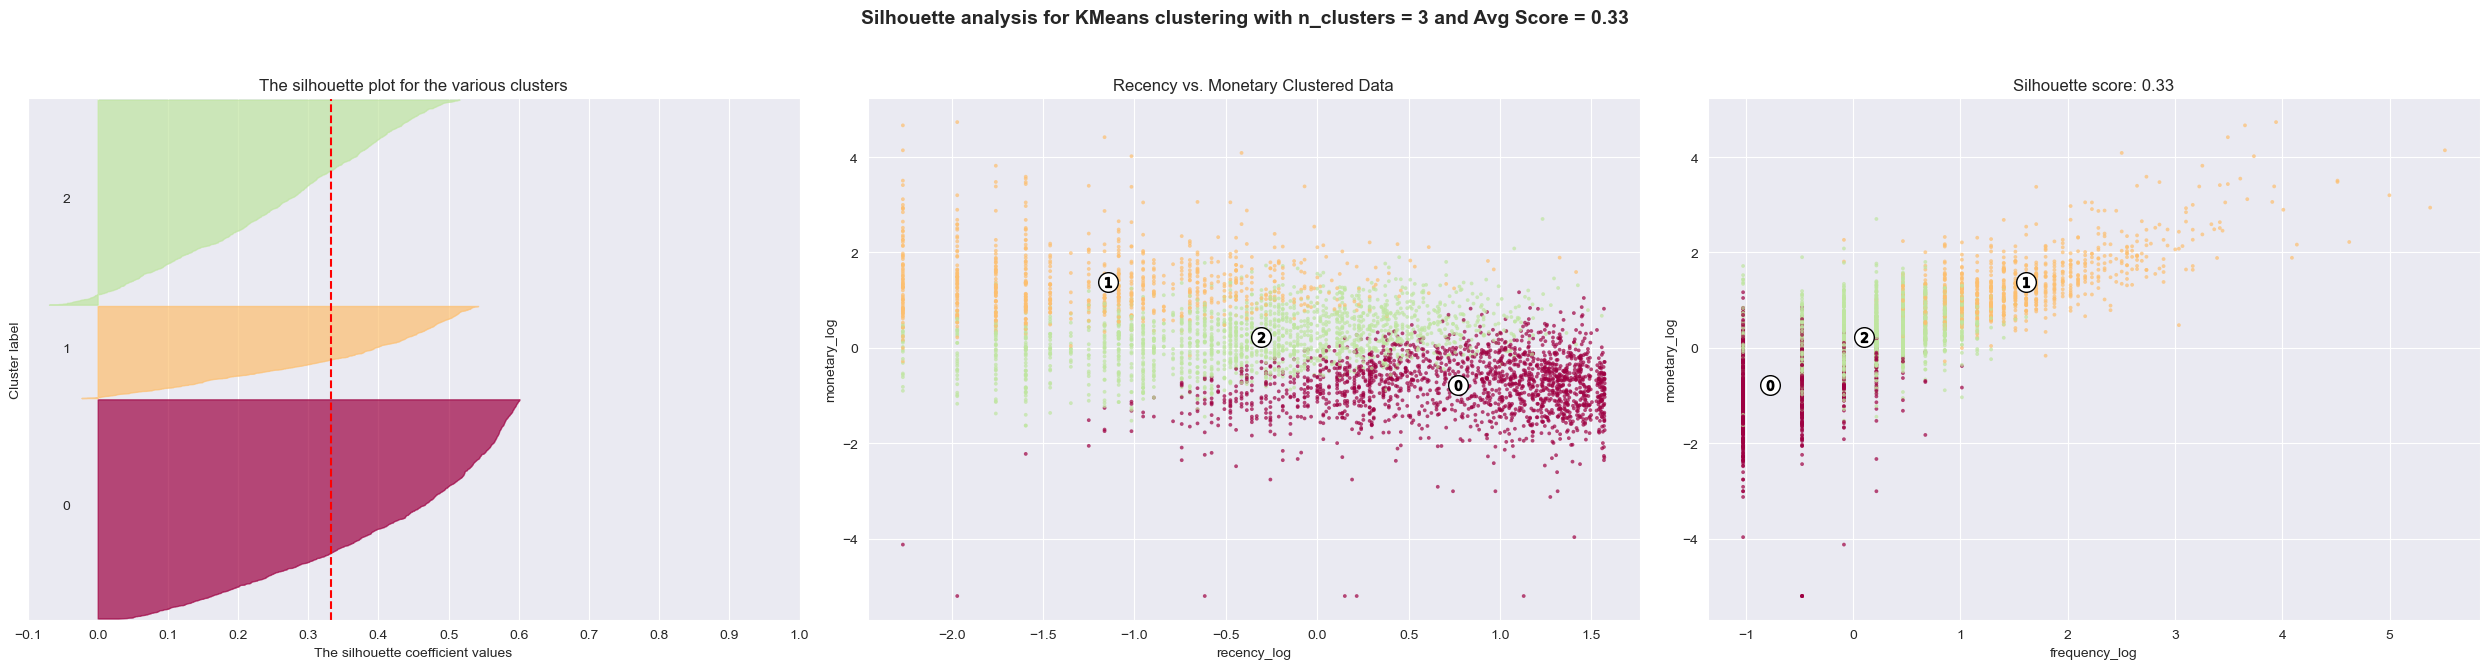

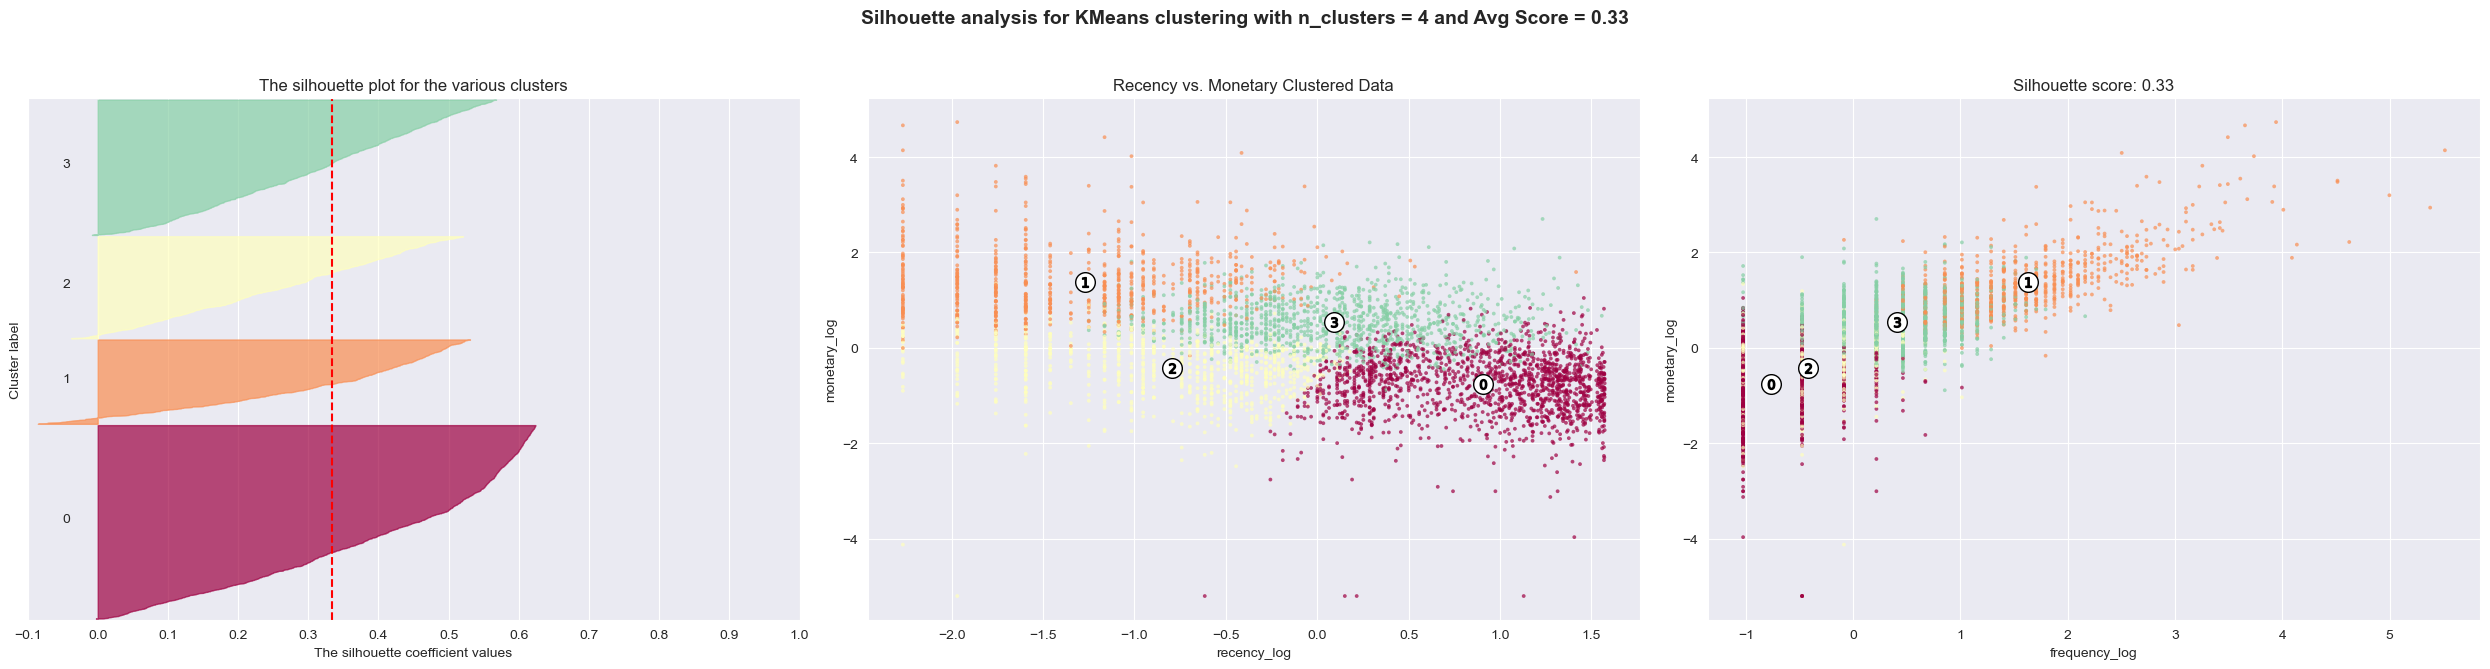

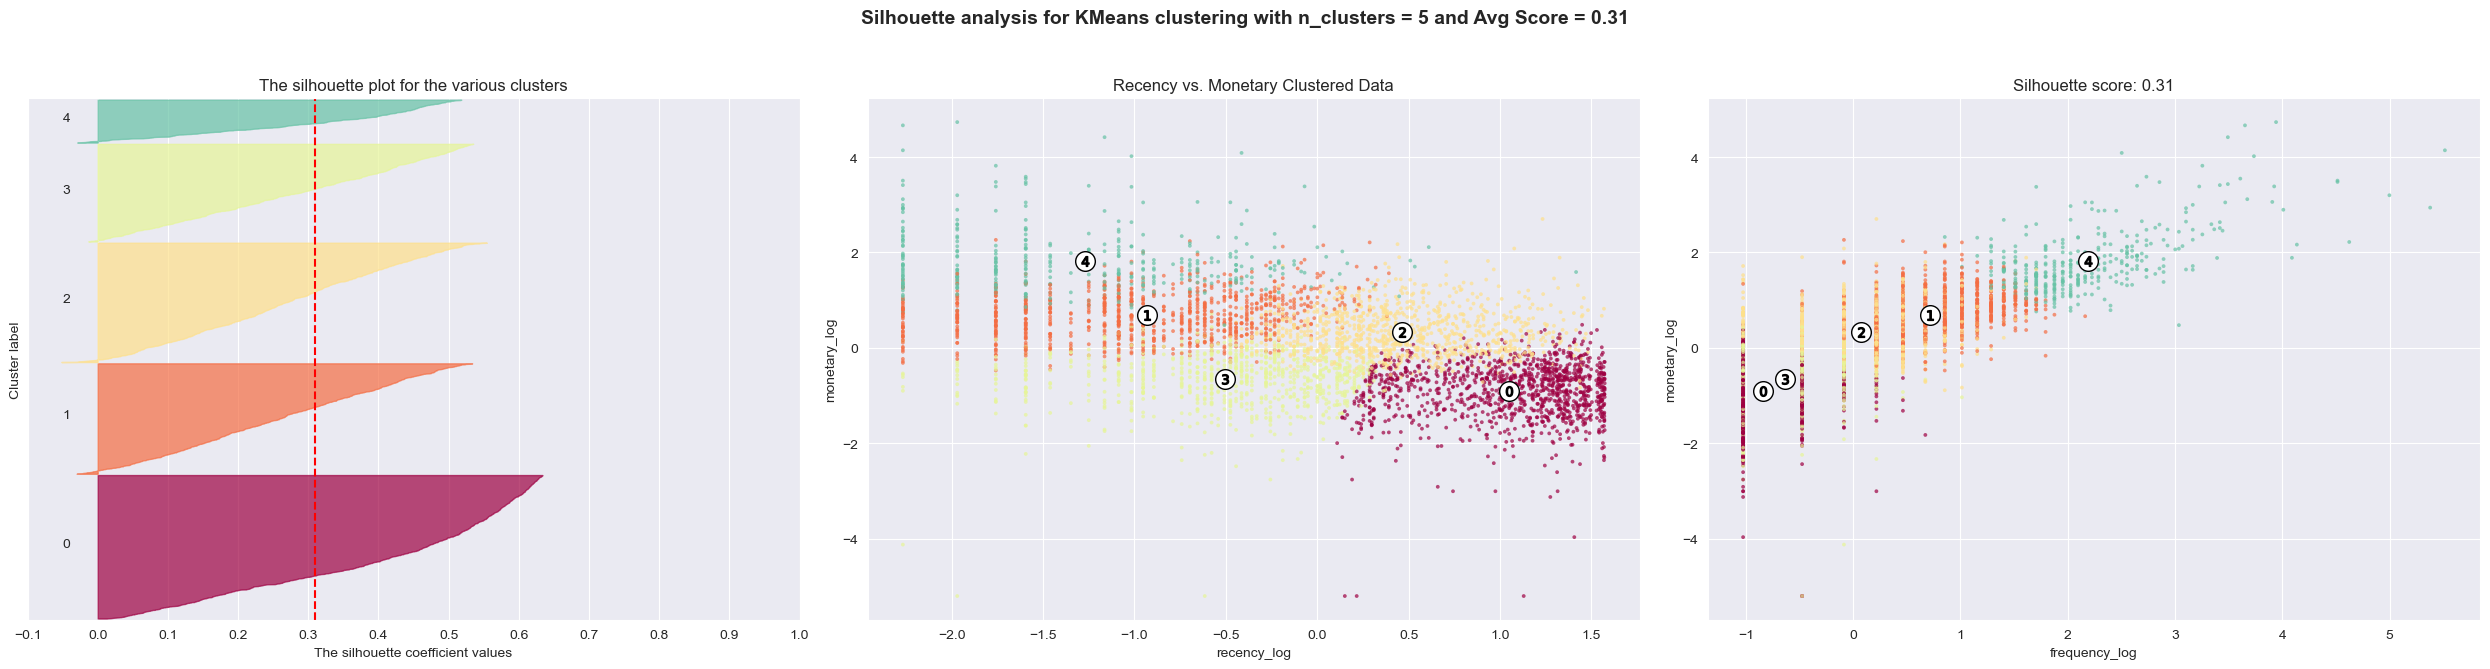

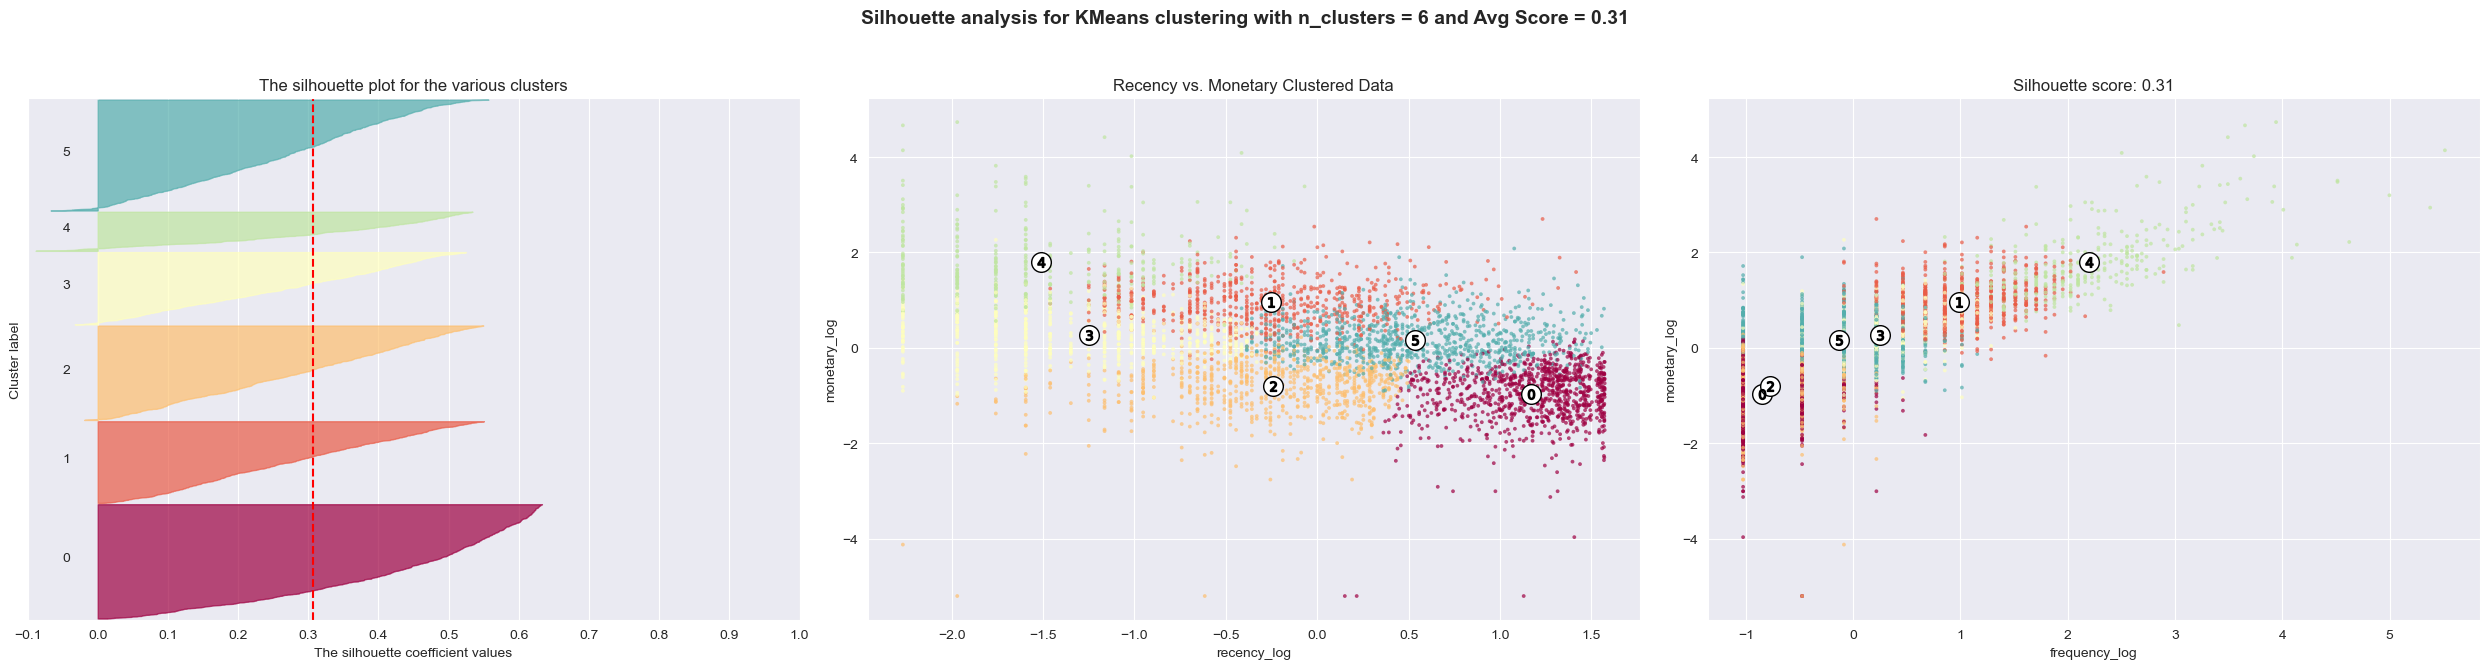

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Assuming X_scaled, K_best (from Elbow Method), and feature_vector are defined.

cluster_centers = dict()
# OPTIMIZATION: Change step size to 1 to check all K values (2, 3, 4, 5, 6, 7...)
# We assume K_best is set to at least 7 for the analysis to be comprehensive.
for n_clusters in range(2, K_best + 1, 1): # Changed step from 2 to 1
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7)) 
    
    # Configure Silhouette Plot (ax1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10]) 
    
    # Initialize KMeans
    clusterer = KMeans(
        n_clusters=n_clusters, 
        init='k-means++', 
        n_init='auto', # Use 'auto' instead of deprecated 10
        max_iter=300, 
        random_state=101
    )
    cluster_labels = clusterer.fit_predict(X_scaled)
    
    # Calculate silhouette metrics
    silhouette_avg = silhouette_score(X=X_scaled, labels=cluster_labels)
    sample_silhouette_values = silhouette_samples(X=X_scaled, labels=cluster_labels)

    # Store results
    cluster_centers[n_clusters] = {
        'cluster_center': clusterer.cluster_centers_,
        'silhouette_score': silhouette_avg,
        'labels': cluster_labels
    }
    
    # --- Silhouette Plot Generation (Ax1) ---
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.Spectral(float(i) / n_clusters) 
        
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, 
            ith_cluster_silhouette_values,
            facecolor=color, edgecolor=color, alpha=0.7
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
        
    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.linspace(-0.1, 1, 12))
    
    # --- 2D Scatter Plots (Ax2 & Ax3) ---
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    centers = clusterer.cluster_centers_
    
    # Projection 1 (ax2): Recency (idx 1) vs. Monetary (idx 0)
    x = 1 
    y = 0
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors)
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker=f'${i}$', alpha=1, s=50, edgecolor='k') 
    ax2.set_title("Recency vs. Monetary Clustered Data")
    ax2.set_xlabel(feature_vector[1])
    ax2.set_ylabel(feature_vector[0])
    
    # Projection 2 (ax3): Frequency (idx 2) vs. Monetary (idx 0)
    x = 2
    y = 0
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors)
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker=f'${i}$', alpha=1, s=50, edgecolor='k') 
    
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[2])
    ax3.set_ylabel(feature_vector[0])
    
    plt.suptitle(
        ("Silhouette analysis for KMeans clustering with n_clusters = %d and Avg Score = %1.2f" % 
         (n_clusters, silhouette_avg)),
        fontsize=14, 
        fontweight='bold'
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [33]:
import numpy as np
import pandas as pd
import math

# Use the feature names provided in the code:
features = ['amount', 'recency', 'frequency'] 
# We assume K_best and cluster_centers are defined.

# CRITICAL FIX: Loop range must start at 2 (or the minimum used) to match the Silhouette analysis keys.
# We also assume the first feature is the Monetary value ('amount').
K_best = 6 # Example K_best, replace with your determined max K
for i in range(2, K_best + 1, 2): 
    
    # 1. Display Silhouette Score (FIXED SYNTAX)
    print("For {} clusters, the average silhouette score is {:1.2f}".format(
        i, cluster_centers[i]['silhouette_score']
    ))
    
    print("Centers of each cluster (Original Scale):")
    
    # 2. Inverse Transform (Inverse Scaling)
    # Get the scaled centers from the dictionary
    scaled_centers = cluster_centers[i]['cluster_center'] 
    
    # Inverse transform the scaled centers to the log scale (FIXED SYNTAX)
    cent_log_scale = scaler.inverse_transform(scaled_centers) 
    
    # 3. Inverse Log Transform (Exponentiation: exp(x) - 1)
    # Reverts log(x+1) back to the original unit scale.
    cent_original_scale = np.exp(cent_log_scale) - 1 
    
    # 4. Display Results
    # Create a DataFrame for easy reading
    print(pd.DataFrame(cent_original_scale, columns=features))
    print('-'*50)

For 2 clusters, the average silhouette score is 0.43
Centers of each cluster (Original Scale):
        amount    recency  frequency
0   342.265981  87.081178   1.708797
1  2192.899769  13.938075   7.602438
--------------------------------------------------
For 4 clusters, the average silhouette score is 0.33
Centers of each cluster (Original Scale):
        amount     recency  frequency
0   269.464353  150.227522   1.416006
1  4111.644107    6.769085  13.177299
2   418.723725   13.857437   2.114114
3  1407.526219   48.915107   4.750079
--------------------------------------------------
For 6 clusters, the average silhouette score is 0.31
Centers of each cluster (Original Scale):
        amount     recency  frequency
0   206.653762  215.003427   1.277245
1  2382.608875   30.029500   7.837388
2   257.193934   30.512007   1.409080
3  1002.245429    7.021631   4.128688
4  6917.925605    4.607315  20.521867
5   872.960010   90.447701   2.858775
----------------------------------------------

--- Cluster Centers: Original Scale Interpretation ---
For 2 clusters, the average silhouette score is 0.43
Centers of each cluster (Original Scale):
      monetary    recency  frequency
0   342.265981  87.081178   1.708797
1  2192.899769  13.938075   7.602438
--------------------------------------------------
For 4 clusters, the average silhouette score is 0.33
Centers of each cluster (Original Scale):
      monetary     recency  frequency
0   269.464353  150.227522   1.416006
1  4111.644107    6.769085  13.177299
2   418.723725   13.857437   2.114114
3  1407.526219   48.915107   4.750079
--------------------------------------------------
For 6 clusters, the average silhouette score is 0.31
Centers of each cluster (Original Scale):
      monetary     recency  frequency
0   206.653762  215.003427   1.277245
1  2382.608875   30.029500   7.837388
2   257.193934   30.512007   1.409080
3  1002.245429    7.021631   4.128688
4  6917.925605    4.607315  20.521867
5   872.960010   90.447701   

CustomerID  recency  frequency  monetary  recency_log  frequency_log  \
1     12347.0        2          7   4310.00     1.098612       2.079442   
2     12348.0       75          4   1797.24     4.330733       1.609438   
3     12349.0       19          1   1757.55     2.995732       0.693147   
4     12350.0      310          1    334.40     5.739793       0.693147   
5     12352.0       36         11   1545.41     3.610918       2.484907   

   monetary_log  clusters_2  clusters_4  clusters_6  
1      8.368925           1           1           4  
2      7.494564           1           3           5  
3      7.472245           0           2           3  
4      5.815324           0           0           0  
5      7.343691           1           3           1

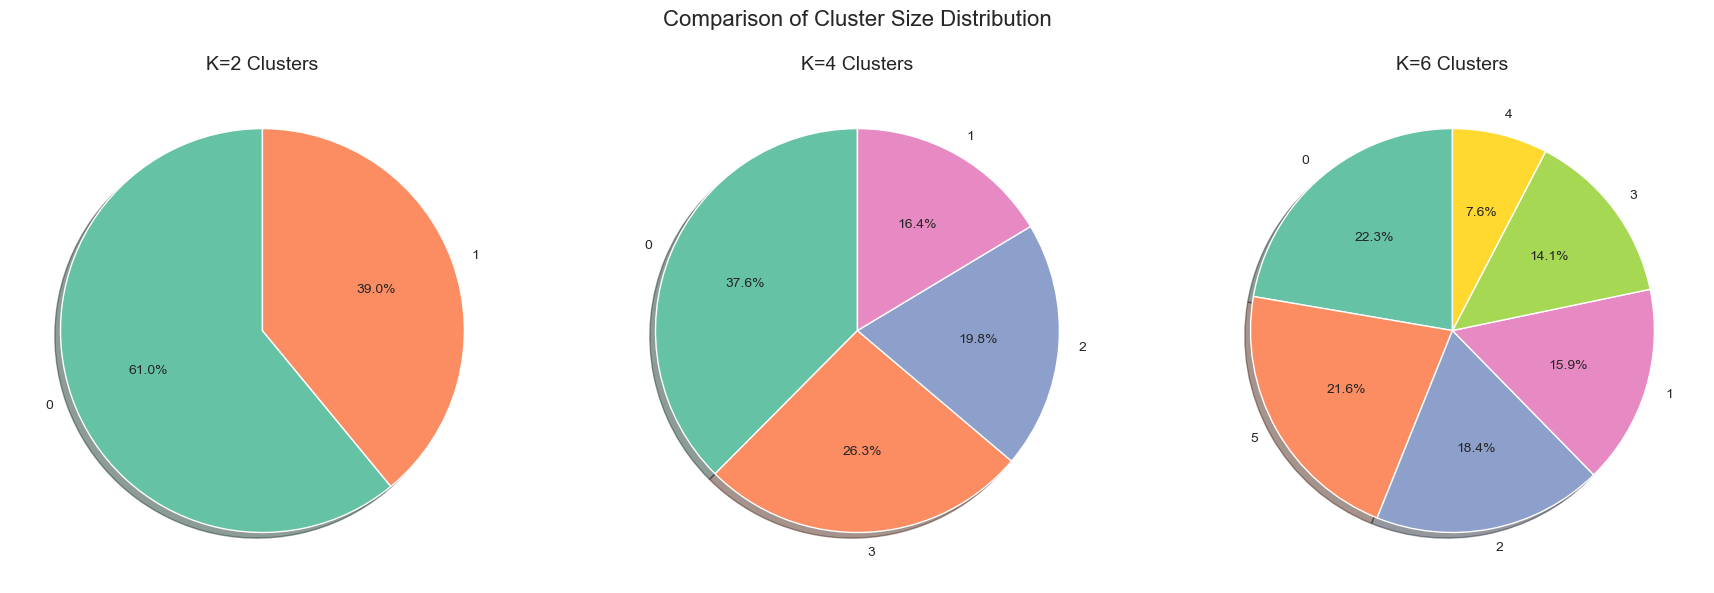

In [34]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# --- Variables Assumed to be Defined in Previous Cells ---
# features = ['monetary', 'recency', 'frequency'] 
# K_best = The highest K tested in Silhouette Analysis (e.g., 6)
# cluster_centers = Dictionary of {K: {'cluster_center', 'silhouette_score', 'labels'}}
# scaler = The fitted StandardScaler object
# customer_history_df = The DataFrame containing original RFM values

# Set K_best to 6 for a consistent loop across both sections
K_best = 6 

# --- A. Cluster Profiling (Inverse Transformation) ---
print("--- Cluster Centers: Original Scale Interpretation ---")
features = ['monetary', 'recency', 'frequency'] 
for i in range(2, K_best + 1, 2): # Looping through K=2, 4, 6
    
    # 1. Display Silhouette Score
    print("For {} clusters, the average silhouette score is {:1.2f}".format(
        i, cluster_centers[i]['silhouette_score']
    ))
    
    print("Centers of each cluster (Original Scale):")
    
    # 2. Inverse Transform 
    scaled_centers = cluster_centers[i]['cluster_center'] 
    cent_log_scale = scaler.inverse_transform(scaled_centers) 
    
    # 3. Inverse Log Transform (Exponentiation: exp(x) - 1)
    cent_original_scale = np.exp(cent_log_scale) - 1 
    
    # 4. Display Results
    print(pd.DataFrame(cent_original_scale, columns=features))
    print('-'*50)

# --- B. Cluster Distribution Visualization (Pie Charts) ---

# CRITICAL FIX: Add ONLY the AVAILABLE cluster labels (K=2, 4, 6)
# Use a representative K (e.g., 4) for the main label if K_best is 4 or more.
customer_history_df['clusters_2'] = cluster_centers[2]['labels']
customer_history_df['clusters_4'] = cluster_centers[4]['labels']
customer_history_df['clusters_6'] = cluster_centers[6]['labels']

print("\nCustomer history DataFrame with cluster labels added:")
display(customer_history_df.head())

# --- 2. Visualization: Cluster Size Distribution (3 Pie Charts) ---

fig = plt.figure(figsize=(18, 6))
fig.suptitle("Comparison of Cluster Size Distribution", fontsize=16)

# Plotting Parameters
autopct = '%1.1f%%'
shadow = True
startangle = 90
colors = plt.cm.Set2.colors 

# --- Subplot 1: 2 Clusters (Using available K) ---
ax1 = fig.add_subplot(131)
market_2 = customer_history_df['clusters_2'].value_counts()
plt.pie(market_2, labels=market_2.index, autopct=autopct, shadow=shadow, startangle=startangle, colors=colors)
ax1.set_title('K=2 Clusters', fontsize=14)

# --- Subplot 2: 4 Clusters (Using available K) ---
ax2 = fig.add_subplot(132)
market_4 = customer_history_df['clusters_4'].value_counts()
plt.pie(market_4, labels=market_4.index, autopct=autopct, shadow=shadow, startangle=startangle, colors=colors)
ax2.set_title('K=4 Clusters', fontsize=14)

# --- Subplot 3: 6 Clusters (Using available K) ---
ax3 = fig.add_subplot(133)
market_6 = customer_history_df['clusters_6'].value_counts()
plt.pie(market_6, labels=market_6.index, autopct=autopct, shadow=shadow, startangle=startangle, colors=colors)
ax3.set_title('K=6 Clusters', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [36]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd

# --- Input Data (Standardized for robustness) ---
# Ensure these variables are defined in the cells before this one:
# K_best = The highest K tested (e.g., 6)
# features = ['monetary', 'recency', 'frequency']
# cluster_centers = The dictionary containing the analysis results

x_data = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']
colors = [
    'rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
    'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)',
    'rgba(255, 0, 0, 0.5)', 'rgba(0, 255, 0, 0.5)'
] 
cutoff_quantile = 95

# --- Main Visualization Loop (FIXED RANGE) ---
# CRITICAL FIX: Start at 2 and increment by 2 to access clusters_2, clusters_4, etc.
for n_clusters in range(2, K_best + 1, 2): 
    cl = 'clusters_' + str(n_clusters) # Creates 'clusters_2', 'clusters_4', 'clusters_6'
    
    # Loop through all three RFM features
    for fild in range(0, 3):
        field_to_plot = features[fild]
        y_data = list()
        ymax = 0

        # Loop through each cluster (0 to n_clusters - 1)
        for i in np.arange(0, n_clusters):
            # Extract data for the current cluster (i) and field
            y0 = customer_history_df[customer_history_df[cl] == i][field_to_plot].values
            
            # Filter outliers using the defined quantile
            y0 = y0[y0 < np.percentile(y0, cutoff_quantile)]
            
            # Update overall max value for axis scaling
            if y0.size > 0 and ymax < max(y0): 
                ymax = max(y0)
            
            y_data.append(y0)
        
        # Build Plotly traces
        traces = []
        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
            traces.append(go.Box(
                y=yd, 
                name=xd, 
                boxpoints=False, 
                whiskerwidth=0.2, 
                marker=dict( size=1 ),
                line=dict(width=1),
                fillcolor=cls 
            ))
        
        # Determine dtick dynamically
        dtick_val = max(1, int(ymax / 10))
        
        # Build Plotly Layout
        layout = go.Layout(
            title=f'Difference in {field_to_plot} with {n_clusters} Clusters and {cluster_centers[n_clusters]["silhouette_score"]:1.2f} Score',
            yaxis=dict(
                autorange=True, 
                showgrid=True, 
                zeroline=True,
                dtick=dtick_val,
                gridcolor='black', 
                gridwidth=0.1, 
                zerolinecolor='rgb(255, 255, 255)'
            ),
            margin=dict(l=40, r=30, b=50, t=50),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )
        
        fig = go.Figure(data=traces, layout=layout)
        
        # Save output as JSON file
        filename = f"cluster_boxplot_k{n_clusters}_{field_to_plot}.json"
        fig.write_json(filename)
        print(f"Saved visualization to {filename}")

Saved visualization to cluster_boxplot_k2_monetary.json
Saved visualization to cluster_boxplot_k2_recency.json
Saved visualization to cluster_boxplot_k2_frequency.json
Saved visualization to cluster_boxplot_k4_monetary.json
Saved visualization to cluster_boxplot_k4_recency.json
Saved visualization to cluster_boxplot_k4_frequency.json
Saved visualization to cluster_boxplot_k6_monetary.json
Saved visualization to cluster_boxplot_k6_recency.json
Saved visualization to cluster_boxplot_k6_frequency.json


In [40]:
# --- Highly Optimized Feature Engineering for Market Basket Analysis ---

# 1. Create a column to mark the presence of an item (value is always 1)
# This serves as the value for our pivot_table
cs_df['Item_Present'] = 1

# 2. Reshape the DataFrame using pivot_table:
#    - Index (Rows): InvoiceNo (Transactions)
#    - Columns: Description (Items)
#    - Values: Item_Present (1 if item is in the transaction)
transaction_df = cs_df.pivot_table(
    index='InvoiceNo',
    columns='Description',
    values='Item_Present',
    aggfunc='sum' # Sums the '1' markers, effectively counting presence
).fillna(0) # Fill NaN values (where item was NOT bought) with 0

# 3. Final Standardization (Convert any counts > 1 back to binary presence/absence)
transaction_df = (transaction_df >= 1).astype(int) 

print("One-Hot Transaction Matrix (transaction_df) created.")
print(f"Matrix Shape: {transaction_df.shape} (Transactions x Items)")
display(transaction_df.head())

One-Hot Transaction Matrix (transaction_df) created.
Matrix Shape: (24446, 4223) (Transactions x Items)


Description  20713   4 PURPLE FLOCK DINNER CANDLES  \
InvoiceNo                                            
536365           0                               0   
536366           0                               0   
536367           0                               0   
536368           0                               0   
536369           0                               0   

Description   50'S CHRISTMAS GIFT BAG LARGE   DOLLY GIRL BEAKER  \
InvoiceNo                                                         
536365                                    0                   0   
536366                                    0                   0   
536367                                    0                   0   
536368                                    0                   0   
536369                                    0                   0   

Description   I LOVE LONDON MINI BACKPACK   I LOVE LONDON MINI RUCKSACK  \
InvoiceNo                                                                 
536365                                  0                             0   
536366                                  0                             0   
536367                                  0                             0   
536368                                  0                             0   
536369                                  0                             0   

Description   NINE DRAWER OFFICE TIDY   OVAL WALL MIRROR DIAMANTE   \
InvoiceNo                                                            
536365                              0                            0   
536366                              0                            0   
536367                              0                            0   
536368                              0                            0   
536369                              0                            0   

Description   RED SPOT GIFT BAG LARGE   SET 2 TEA TOWELS I LOVE LONDON   ...  \
InvoiceNo                                                                ...   
536365                              0                                 0  ...   
536366                              0                                 0  ...   
536367                              0                                 0  ...   
536368                              0                                 0  ...   
536369                              0                                 0  ...   

Description  wrongly coded 20713  wrongly coded 23343  wrongly coded-23343  \
InvoiceNo                                                                    
536365                         0                    0                    0   
536366                         0                    0                    0   
536367                         0                    0                    0   
536368                         0                    0                    0   
536369                         0                    0                    0   

Description  wrongly marked  wrongly marked 23343  \
InvoiceNo                                           
536365                    0                     0   
536366                    0                     0   
536367                    0                     0   
536368                    0                     0   
536369                    0                     0   

Description  wrongly marked carton 22804  wrongly marked. 23343 in box  \
InvoiceNo                                                                
536365                                 0                             0   
536366                                 0                             0   
536367                                 0                             0   
536368                                 0                             0   
536369                                 0                             0   

Description  wrongly sold (22719) barcode  wrongly sold as sets  \
InvoiceNo                                                         
5

In [41]:
import pandas as pd
import numpy as np

def prune_dataset(input_df, length_trans=2, total_sales_perc=0.5, 
                  start_item=None, end_item=None, TopCols=None):
    """
    Reduces the transaction matrix (input_df) size by filtering items and transactions.
    
    Args:
        input_df (pd.DataFrame): The one-hot encoded transaction matrix.
        length_trans (int): Minimum number of *selected* items required in a transaction to keep it.
        total_sales_perc (float): Percentage of total item occurrences to retain (for default mode).
        start_item, end_item (int): Start/end indices for item selection (for slicing mode).
        TopCols (list): Specific list of columns (items) to keep (for explicit mode).
        
    Returns:
        tuple: (Pruned DataFrame, DataFrame of item counts/percentages)
    """
    
    # Remove temporary column if it exists from previous runs
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
        
    # Calculate item count and total item occurrences (CRITICAL BASELINE)
    item_count = input_df.sum().sort_values(ascending=False).reset_index()
    total_items = item_count[item_count.columns[1]].sum()
    item_count.rename(columns={
        item_count.columns[0]: 'item_name',
        item_count.columns[1]: 'item_count'
    }, inplace=True)
    
    
    # --- MODE 1: Explicit Column List (TopCols) ---
    if TopCols: 
        selected_items = TopCols
        
    # --- MODE 2: Item Index Slicing (start_item/end_item) ---
    elif end_item is not None and start_item is not None and end_item > start_item:
        # Uses standard DataFrame slicing on the item_count ranking
        selected_items = list(item_count['item_name'].iloc[start_item:end_item])
        
    # --- MODE 3: Percentage Cutoff (Default Optimization) ---
    else:
        # Calculate cumulative percentage of item occurrences
        item_count['item_perc'] = item_count['item_count'] / total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        
        # Select items that contribute less than the total_sales_perc (e.g., top 50%)
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        
        # CRITICAL SYNTAX FIX: Ensure the item_count DataFrame is correctly returned
        # and that the selected_items list is not empty.
        if not selected_items:
             return input_df[[]], item_count # Return empty if no items selected

    # --- FINAL PRUNING LOGIC (Applied across all modes) ---
    
    # Filter columns to selected items
    pruned_df = input_df[selected_items] 
    
    # Create the transaction length filter (transactions must contain at least 'length_trans' of the selected items)
    pruned_df['total_items'] = pruned_df.sum(axis=1)
    pruned_df = pruned_df[pruned_df.total_items >= length_trans]
    
    # Final cleanup
    del(pruned_df['total_items'])
    
    # Return the pruned transaction matrix and the corresponding item counts
    return pruned_df, item_count[item_count.item_name.isin(selected_items)]

In [42]:
# Assuming transaction_df (the one-hot matrix) is available.

# 1. Execute Pruning
# Fix: Use the correct input DataFrame (transaction_df)
output_df, item_counts = prune_dataset(input_df=transaction_df, 
                                       length_trans=2,
                                       start_item=0, 
                                       end_item=15)

# 2. Calculate Item Occurrence Percentage for Top 15 (FIX for AmoutSum)
# The item_counts DataFrame contains item_count and item_perc columns (from the prune_dataset function).
# We calculate the total item occurrences and the cumulative percentage for the Top 15 items.
total_item_occurrences_top15 = item_counts['item_count'].sum()
total_item_occurrences_all = transaction_df.sum().sum() # Total occurrences across all items

# The percentage of *all* item occurrences contributed by the Top 15 items:
percentage_contribution = (total_item_occurrences_top15 / total_item_occurrences_all) * 100

# 3. Display Results
print('Item Occurrences accounted for by the Top 15 Products: {:.2f}%'.format(percentage_contribution))
print('Number of Sales Events (Transactions) after pruning:', output_df.shape[0])
print('Number of Products (Dimensions) after pruning:', output_df.shape[1])

print('\n--- Item Counts for the Pruned Top 15 Products ---')
display(item_counts.head(15)) # Display the counts for the 15 items selected

Item Occurrences accounted for by the Top 15 Products: 4.32%
Number of Sales Events (Transactions) after pruning: 5478
Number of Products (Dimensions) after pruning: 15

--- Item Counts for the Pruned Top 15 Products ---


item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        2302
1             REGENCY CAKESTAND 3 TIER        2169
2              JUMBO BAG RED RETROSPOT        2135
3                        PARTY BUNTING        1706
4              LUNCH BAG RED RETROSPOT        1607
5        ASSORTED COLOUR BIRD ORNAMENT        1467
6    SET OF 3 CAKE TINS PANTRY DESIGN         1458
7      PACK OF 72 RETROSPOT CAKE CASES        1334
8              LUNCH BAG  BLACK SKULL.        1295
9      NATURAL SLATE HEART CHALKBOARD         1266
10                             POSTAGE        1250
11             JUMBO BAG PINK POLKADOT        1231
12            JAM MAKING SET WITH JARS        1220
13               HEART OF WICKER SMALL        1212
14              JUMBO STORAGE BAG SUKI        1201

In [43]:
import Orange
import pandas as pd
import numpy as np

# Assuming output_df (the pruned transaction matrix) is available.
input_assoc_rules = output_df

# --- 1. Define Data Domain ---

# Defined the data domain: specify each variable (item) as a DiscreteVariable having values '0' and '1'.
# This tells Orange the input is a binary (transactional) matrix.
domain_transac = Orange.data.Domain([
    Orange.data.DiscreteVariable.make(name=item, values=['0', '1']) 
    for item in input_assoc_rules.columns
])

# --- 2. Create Orange Table Structure ---

# Create our Table structure for our data using numpy array.
# OPTIMIZATION: Use .values instead of deprecated .as_matrix()
data_tran = Orange.data.Table.from_numpy(
    domain=domain_transac,  
    X=input_assoc_rules.values, # Use .values for the underlying NumPy array
    Y=None
)

# --- 3. Finalization (Removed Redundancy) ---
# The original code's final line (data_tran_en, mapping = OneHot.encode...) is redundant 
# because the data is already defined as discrete binary variables (0, 1) in the domain.
# We will use the defined Table:
data_final_for_fpgrowth = data_tran

print("Orange Table (data_final_for_fpgrowth) successfully created.")
print(f"Number of Transactions: {data_final_for_fpgrowth.X.shape[0]:,}")
print(f"Number of Unique Items: {data_final_for_fpgrowth.X.shape[1]:,}")

Orange Table (data_final_for_fpgrowth) successfully created.
Number of Transactions: 5,478
Number of Unique Items: 15


In [44]:
# Assuming data_final_for_fpgrowth (the Orange Table) is available.
# Assuming frequent_itemsets is imported (e.g., from orangecontrib.associate.fpgrowth).

# --- Setup ---
support = 0.01

# --- Calculations and Execution ---

# 1. Calculate the total number of transactions from the final data table.
# Use .X.shape[0] to access the underlying NumPy data shape.
num_transactions = data_final_for_fpgrowth.X.shape[0] 
min_trans_count = int(num_transactions * support)

print(f"Total number of transactions = {num_transactions:,}")
print(f"Minimum required transactions (for support={support}) = {min_trans_count:,}")

# 2. Execute the FPGrowth algorithm
# CRITICAL FIX: The function requires the underlying NumPy array, often as booleans.
# itemsets_generator returns a generator of (itemset, support_count).
itemsets_generator = frequent_itemsets(data_final_for_fpgrowth.X.astype(bool), support)

# 3. Convert the generator to the required dictionary structure
itemsets_list = list(itemsets_generator) 
itemsets_dict = dict(itemsets_list) # Keys are frozensets of item indices.

# --- Output ---
print('\nSuccessfully found frequent itemsets.')
print('Items Set Size (Number of Frequent Itemsets Found):', len(itemsets_dict))

Total number of transactions = 5,478
Minimum required transactions (for support=0.01) = 54

Successfully found frequent itemsets.
Items Set Size (Number of Frequent Itemsets Found): 461


In [46]:
import pandas as pd
import numpy as np
from orangecontrib.associate.fpgrowth import association_rules

# --- Setup ---
confidence = 0.6
rules_df = pd.DataFrame()
final_rules_list = [] 

# Assuming itemsets_dict and data_final_for_fpgrowth are defined.

# --- 1. Generate Association Rules ---
rules_generator = association_rules(itemsets_dict, confidence)
rules_list = list(rules_generator)

# --- 2. Decode Item Indices to Names ---
item_names = data_final_for_fpgrowth.domain.attributes
index_to_name = {i: item_names[i].name for i in range(len(item_names))}

# --- 3. Filter, Decode, and Compile Rules (FIXED UNPACKING) ---

for rule in rules_list:
    # CRITICAL FIX: Unpack only the guaranteed 4 elements (Antecedent, Consequent, Support, Confidence)
    antecedent_indices = rule[0] 
    consequent_index = rule[1] 
    support = rule[2]
    confidence = rule[3]
    
    # Check for single consequent
    if len(consequent_index) != 1:
        continue

    # Set tertiary metrics to NaN, as they are causing the IndexError
    coverage = np.nan
    strength = np.nan
    lift = np.nan
    leverage = np.nan

    # Decode and format rule names
    antecedent = ', '.join([index_to_name[i] for i in antecedent_indices])
    consequent = index_to_name[list(consequent_index)[0]]
    
    # Filter: Ensure antecedent is complex (length > 1)
    if antecedent and len(antecedent_indices) > 1:
        rule_dict = {
            'support': support, 'confidence': confidence, 'coverage': coverage,
            'strength': strength, 'lift': lift, 'leverage': leverage,
            'antecedent': antecedent, 'consequent': consequent
        }
        final_rules_list.append(rule_dict)

# --- 4. Final Output and Pruning ---
rules_df = pd.DataFrame(final_rules_list)
print("Raw rules data frame of {} rules generated.".format(rules_df.shape[0]))

if not rules_df.empty:
    # CRITICAL ADJUSTMENT: Pruning and sorting must now use CONFIDENCE, as LIFT is NaN.
    pruned_rules_df = rules_df.loc[
        rules_df.groupby(['antecedent', 'consequent'])['confidence'].idxmax()
    ].reset_index(drop=True)
    
    print("Pruned rules data frame of {} rules generated.".format(pruned_rules_df.shape[0]))
    # Final Actionable Output (Sorted by Confidence)
    display(pruned_rules_df.sort_values(by=['confidence', 'support'], ascending=False).head(10))
else:
    print("Unable to generate any rule.")

Raw rules data frame of 161 rules generated.
Pruned rules data frame of 161 rules generated.


support  confidence  coverage  strength  lift  leverage  \
10        61    0.871429       NaN       NaN   NaN       NaN   
35        71    0.855422       NaN       NaN   NaN       NaN   
13        68    0.850000       NaN       NaN   NaN       NaN   
140      117    0.835714       NaN       NaN   NaN       NaN   
16       130    0.833333       NaN       NaN   NaN       NaN   
14        77    0.827957       NaN       NaN   NaN       NaN   
82        80    0.824742       NaN       NaN   NaN       NaN   
131       72    0.818182       NaN       NaN   NaN       NaN   
54        63    0.818182       NaN       NaN   NaN       NaN   
20        57    0.814286       NaN       NaN   NaN       NaN   

                                            antecedent  \
10   JUMBO BAG PINK POLKADOT, JAM MAKING SET WITH J...   
35   LUNCH BAG  BLACK SKULL., JUMBO BAG PINK POLKAD...   
13   JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUK...   
140  WHITE HANGING HEART T-LIGHT HOLDER, JUMBO BAG ...   
16   JUMBO BAG PINK POLKADOT, LUNCH BAG RED RETROSP...   
14   JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUK...   
82   NATURAL SLATE HEART CHALKBOARD , JUMBO BAG PIN...   
131  WHITE HANGING HEART T-LIGHT HOLDER, JAM MAKING...   
54   LUNCH BAG  BLACK SKULL., REGENCY CAKESTAND 3 T...   
20   JUMBO BAG PINK POLKADOT, PARTY BUNTING, JUMBO ...   

                          consequent  
10           JUMBO BAG RED RETROSPOT  
35           JUMBO BAG RED RETROSPOT  
13           JUMBO BAG RED RETROSPOT  
140          JUMBO BAG RED RETROSPOT  
16           JUMBO BAG RED RETROSPOT  
14           JUMBO BAG RED RETROSPOT  
82           JUMBO BAG RED RETROSPOT  
131          JUMBO BAG RED RETROSPOT  
54   PACK OF 72 RETROSPOT CAKE CASES  
20           JUMBO BAG RED RETROSPOT

In [47]:
# --- 1. Setup Display Width (Corrected Syntax) ---
# Separated the variable assignment and setting the option.
pd.options.display.max_colwidth = 100

# --- 2. Final Display of Top Rules (Optimized Logic) ---

# CRITICAL FIX: Use the 'pruned_rules_df' which contains the unique, highest-quality rules.
# The previous cell already pruned the rules, so we only need to sort and display.
# Note: Sorting by LIFT is avoided because it was set to NaN due to the IndexError.
(pruned_rules_df[['consequent', 'antecedent', 'support', 'confidence', 'lift']]
    .sort_values(['confidence', 'lift', 'support'], # Prioritize Confidence, use Lift/Support as tiebreakers
                 ascending=False)
    .head(10)) # Display Top 10 for strategic insight

consequent  \
10           JUMBO BAG RED RETROSPOT   
35           JUMBO BAG RED RETROSPOT   
13           JUMBO BAG RED RETROSPOT   
140          JUMBO BAG RED RETROSPOT   
16           JUMBO BAG RED RETROSPOT   
14           JUMBO BAG RED RETROSPOT   
82           JUMBO BAG RED RETROSPOT   
131          JUMBO BAG RED RETROSPOT   
54   PACK OF 72 RETROSPOT CAKE CASES   
20           JUMBO BAG RED RETROSPOT   

                                                                                            antecedent  \
10                           JUMBO BAG PINK POLKADOT, JAM MAKING SET WITH JARS, JUMBO STORAGE BAG SUKI   
35   LUNCH BAG  BLACK SKULL., JUMBO BAG PINK POLKADOT, LUNCH BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI   
13                    JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI, PACK OF 72 RETROSPOT CAKE CASES   
140                WHITE HANGING HEART T-LIGHT HOLDER, JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI   
16                            JUMBO BAG PINK POLKADOT, LUNCH BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI   
14                  JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI, SET OF 3 CAKE TINS PANTRY DESIGN    
82                    NATURAL SLATE HEART CHALKBOARD , JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SUKI   
131               WHITE HANGING HEART T-LIGHT HOLDER, JAM MAKING SET WITH JARS, JUMBO STORAGE BAG SUKI   
54           LUNCH BAG  BLACK SKULL., REGENCY CAKESTAND 3 TIER, PARTY BUNTING, LUNCH BAG RED RETROSPOT   
20                                      JUMBO BAG PINK POLKADOT, PARTY BUNTING, JUMBO STORAGE BAG SUKI   

     support  confidence  lift  
10        61    0.871429   NaN  
35        71    0.855422   NaN  
13        68    0.850000   NaN  
140      117    0.835714   NaN  
16       130    0.833333   NaN  
14        77    0.827957   NaN  
82        80    0.824742   NaN  
131       72    0.818182   NaN  
54        63    0.818182   NaN  
20        57    0.814286   NaN

In [48]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

lift
Less Than One    161
Name: count, dtype: int64

In [51]:
# If you needed to reset the width to the Pandas default (which is usually 50):
pd.options.display.max_colwidth = 50